In [2]:
# Hands-On-Advanced-Deep-Learning-Time-Series-Forecasting-with-Tensors-Medium

## url
    # https://medium.com/@dave.cote.msc/hands-on-advanced-deep-learning-time-series-forecasting-with-tensors-7facae522f18

## article title
    # Hands-On Advanced Deep Learning Time Series Forecasting with Tensors

## article by
    # Dave Cote, M.Sc.

## published by
    # Medium

## dataset by
    # author

## publisher url
    # https://medium.com/

## github url
    # https://github.com/CoteDave/blog/blob/master/Hands-on%20Advanced%20Deep%20Learning%20Time%20Series%20Forecasting%20with%20Tensors/Advanced%20DL%20Forecasting%20-%20EASY.ipynb

## 1 Loading Data and Exploration

### 1.1 Environment Setup

In [187]:
!pip install numpy pandas matplotlib seaborn
!pip install scikit-learn
!pip install keras
!pip install tensorflow
!pip install pydot
!pip install graphviz
!pip install statsmodels
!pip install keras-mdn-layer
!pip install tensorflow_probability
!pip install keras_multi_head
!pip install keras-self-attention
!pip install keras-tcn
!pip install numba

In [162]:
# importing libraries
import os
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import LSTM, Bidirectional, Dense, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, GlobalMaxPool1D, Input
from keras.layers import Activation, dot, multiply, concatenate, Layer
from keras.callbacks import Callback, EarlyStopping
from keras.utils.vis_utils import plot_model
import keras.backend as K

from statsmodels.tsa.seasonal import seasonal_decompose

from mdn import MDN, get_mixture_loss_func, sample_from_output
from keras_multi_head import MultiHead, MultiHeadAttention
from keras_self_attention import SeqSelfAttention
from tcn import TCN

# importing custom libraries
from ts_transform import TransformerLog, TransformerDiff
from rdr_scorer import RdR_scorer

In [5]:
import random as python_random

seed_value = 10
# reset the seed values for respective libraries
def reset_seeds(value):
    os.environ['PYTHONHASHSEED']=str(value)
    python_random.seed(value)
    np.random.seed(value)
    tf.random.set_seed(value)
    tf.keras.utils.set_random_seed(value)

reset_seeds(seed_value)

### 1.2 Loading Dataset

In [7]:
ts_sequence = pd.read_csv('./datasets/raw/easy_ts.csv', sep=';')
ts_sequence['DATE'] = pd.to_datetime(ts_sequence['DATE'])

print('ts_sequence', ts_sequence.shape)
ts_original = ts_sequence.copy()

ts_sequence (223, 2)


In [8]:
# parameters for the dataset wrapped in a dictionary
# this is to ensure all the values to be used for this dataset & model building are in one place
dict_ts_sequence = {
    'dataset': ts_sequence, 
    'dataset_orig' : ts_sequence,
    'ts_original': ts_original.copy(),
    'stabilize_variance': False,
    'stabilize_mean': False,
    'seasonal_features': True,
    'diff_trend': False,
    'exog': False,
    'fourier_terms': False,
    
    'date_colname': 'DATE', # name of the date column
    'y_colname': 'EASY', # name of the target column
    'n_lags': 16, # use 16 previous periods to ...
    'n_leads': 24, # ... predict 24 periods ahead
    'freq': 12 # no. of periods in a year
    # (frequency -> 4=quarterly, 12=monthly, 52=weekly, 365=daily)
}

### 1.3 Dataset Exploration

In [9]:
def explore_time_series(data, date_colname, y_colname, exogenous=False):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data[date_colname], data[y_colname])
    plt.title('Time Series Plot')
    plt.show()
    
    if exogenous == True:
        fig, ax = plt.subplots(figsize=(18, 9))
        print('Exogenous Features - Multivariate')
        plt.title('Exogenous Time Series - Multivariate')
        for col in data.columns.difference([date_colname, 'Date', 'date']):
            print(col)
            if col == y_colname:
                ax.plot(data[date_colname], np.log1p(data[col]), linewidth=3)
            else:
                ax.plot(data[date_colname], np.log1p(data[col]), linewidth=1, alpha=0.6)

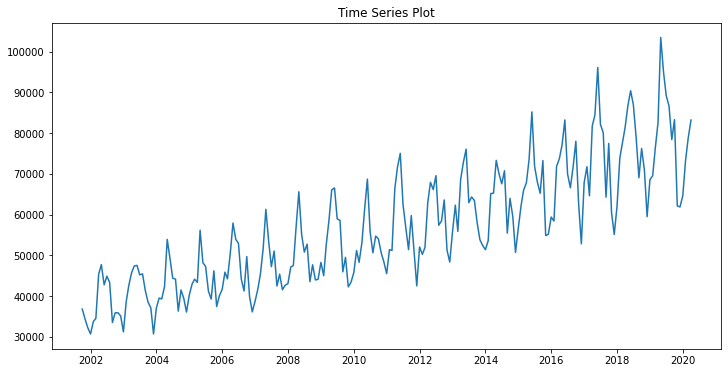

In [10]:
explore_time_series(dict_ts_sequence['dataset'],
                    dict_ts_sequence['date_colname'],
                    dict_ts_sequence['y_colname'])

This time series plot tells us the time series is deterministic and follows a strong upward trend. However, there are some seasonality patterns that we can see in the plot. Every year, there are spikes at around the first quarter of the year. Following the spike, we can see a trough at mid-year, and another spike for the last quarter of the year. This is a typical pattern for a time series that has a yearly seasonality with a strong upward trend.  
  
We can check the seasonal decomposition plot to confirm the seasonality pattern. The seasonal decomposition plot shows the trend, seasonality, and residual components of the time series.

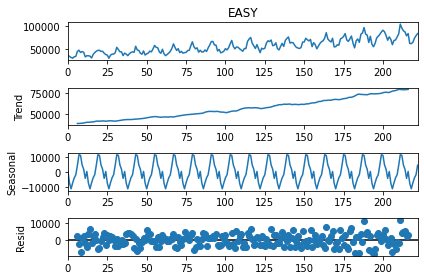

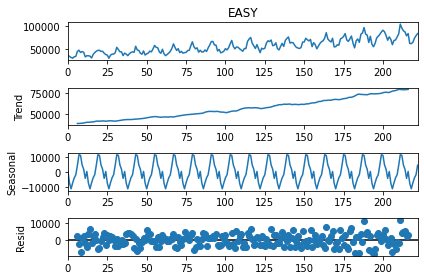

In [11]:
result = seasonal_decompose(ts_sequence[dict_ts_sequence['y_colname']], model='additive', period = dict_ts_sequence['freq'])
result.plot()

## 2 Feature Engineering

### 2.1 Train Test Split function

In [12]:
def split_ts_train_test(ts,
                        date_colname,
                        y_colname_list,
                        n_leads):
    
    ts_train = ts.iloc[:-n_leads, :]
    ts_test = ts.iloc[-n_leads:, :]
       
    return ts, ts_train, ts_test

### 2.2 Feature Extraction - Seasonal Means
We need to calculate the seasonal means for the features.

In [13]:
def seasonal_means_extract(dataset, date_colname, y_colname, n_leads, freq, y_scaler_sequence = None):
    """Calculate the seasonal means of a given time serie

    Args:
        dataset (dataframe): pandas dataframe
        date_colname (str): Name of the date column in the given dataframe
        y_colname (str): Name of the time serie column in the given dataframe
        n_leads (int): number of period to forecast into the futur
        freq (int): frequency, periods of the time series (1=yearly, 12=monthly, 52=weekly, 365=daily)

    Returns:
        list: a list of strings representing the header columns
    """
    keep_cols = list(dataset.columns)
    
    timeserie = dataset[[date_colname, y_colname]].copy()
    if y_scaler_sequence != None:
        timeserie[y_colname] = y_scaler_sequence.inverse_transform(timeserie[[y_colname]]).ravel()
    
    timeserie.index.name = 'index'
    timeserie.index = pd.to_datetime(timeserie[date_colname])
    timeserie.index.name = 'index'
    
    min_year = np.min(timeserie.index.year)
    max_year = np.max(timeserie.index.year) + int(n_leads/freq) + 5

    all_dates = pd.DataFrame(pd.date_range(pd.to_datetime(str(min_year) + '-01-01'),
                  pd.to_datetime(str(max_year) + '-12-31')-timedelta(days=1),freq='d'), columns = ['ds'])

    if freq == 12:

        timeserie['MONTH'] = timeserie.index.month
        timeserie['QUARTER'] = timeserie.index.quarter

        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']

        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
    elif freq == 4:    
        timeserie['QUARTER'] = timeserie.index.quarter.astype(str)
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        
        timeserie['YEAR'] = timeserie.index.year.astype(str)
        timeserie['QUARTER_YEAR'] = timeserie['YEAR'] + '_' + timeserie['QUARTER']

        all_dates['QUARTER'] = all_dates['ds'].dt.quarter.astype(str)
        all_dates['YEAR'] = all_dates['ds'].dt.year.astype(str)
        all_dates['QUARTER_YEAR'] = all_dates['YEAR'] + '_' + all_dates['QUARTER']
        all_dates = all_dates.groupby(['QUARTER_YEAR']).size().reset_index()
        all_dates.columns = ['QUARTER_YEAR', 'N_DAYS']
        

        timeserie1 = pd.merge(timeserie, quarter_mean, how = 'left', 
                              left_on = 'QUARTER', right_on = 'QUARTER')
        timeserie1.index = timeserie.index


    elif freq == 52:   
        timeserie['DAY_OF_MONTH'] = timeserie.index.day
        timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
        timeserie['WEEK'] = timeserie.index.week
        timeserie['MONTH'] = timeserie.index.month
        timeserie['QUARTER'] = timeserie.index.quarter
        timeserie['MONTH_WEEK'] = timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        
        timeserie['YEAR'] = timeserie.index.year.astype(str)
        timeserie['WEEK_YEAR'] = timeserie['YEAR'].astype(str) + '_' + timeserie['WEEK'].astype(str)
        #del timeserie['YEAR']

        all_dates['WEEK'] = all_dates['ds'].dt.week.astype(str)
        all_dates['YEAR'] = all_dates['ds'].dt.year.astype(str)
        all_dates['WEEK_YEAR'] = all_dates['YEAR'] + '_' + all_dates['WEEK']
        all_dates = all_dates.groupby(['WEEK_YEAR']).size().reset_index()
        all_dates.columns = ['WEEK_YEAR', 'N_DAYS']

        #del timeserie['WEEK_YEAR']


        quarter_mean = timeserie[['WEEK', y_colname]].groupby(['WEEK']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['WEEK', 'WEEK_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'WEEK', right_on = 'WEEK')
        #del timeserie['WEEK']
        
        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']
        
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
        day_mean = timeserie[['DAY_OF_MONTH', y_colname]].groupby(['DAY_OF_MONTH']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_MONTH', 'DAY_OF_MONTH_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_MONTH', right_on = 'DAY_OF_MONTH')
        #del timeserie['DAY_OF_MONTH']
        
        day_mean = timeserie[['DAY_OF_WEEK', y_colname]].groupby(['DAY_OF_WEEK']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_WEEK', 'DAY_OF_WEEK_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_WEEK', right_on = 'DAY_OF_WEEK')
        #del timeserie['DAY_OF_WEEK']
    
    elif freq >= 100 and freq <= 600:    
        timeserie['DAY_OF_MONTH'] = timeserie.index.day
        timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
        timeserie['WEEK'] = timeserie.index.week
        timeserie['QUARTER'] = timeserie.index.quarter
        timeserie['MONTH'] = timeserie.index.month
        timeserie['MONTH_WEEK'] = timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        timeserie['WEEKLY_MONTHLY'] = timeserie['DAY_OF_WEEK'].astype(str) + timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        
        timeserie = timeserie.fillna(0)
     
        day_mean = timeserie[['DAY_OF_MONTH', y_colname]].groupby(['DAY_OF_MONTH']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_MONTH', 'DAY_OF_MONTH_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_MONTH', right_on = 'DAY_OF_MONTH')
        #del timeserie['DAY_OF_MONTH']
        
        day_mean = timeserie[['DAY_OF_WEEK', y_colname]].groupby(['DAY_OF_WEEK']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_WEEK', 'DAY_OF_WEEK_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_WEEK', right_on = 'DAY_OF_WEEK')
        #del timeserie['DAY_OF_WEEK']
        
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
        quarter_mean = timeserie[['WEEK', y_colname]].groupby(['WEEK']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['WEEK', 'WEEK_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'WEEK', right_on = 'WEEK')
        #del timeserie['WEEK']
        
        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']
        
        model_mean = timeserie[['WEEKLY_MONTHLY', y_colname]].groupby(['WEEKLY_MONTHLY']).mean([y_colname]).reset_index()
        model_mean.columns = ['WEEKLY_MONTHLY', 'WEEKLY_MONTHLY_MEAN']
        timeserie = pd.merge(timeserie, model_mean, how = 'left', left_on = 'WEEKLY_MONTHLY', right_on = 'WEEKLY_MONTHLY')
        #del timeserie2['MEAN_MODEL']
    
    timeserie.index = pd.to_datetime(dataset[date_colname])
    
    if y_scaler_sequence != None:
        for col in [col for col in timeserie.columns if '_MEAN' in col]:
            timeserie[col] = y_scaler_sequence.transform(timeserie[[col]]).ravel()
    
    add_cols = list(set(keep_cols) - set(timeserie.columns))
    
    for col in add_cols:
        
        timeserie[col] = dataset[col]

    return timeserie

SEASONALITIES


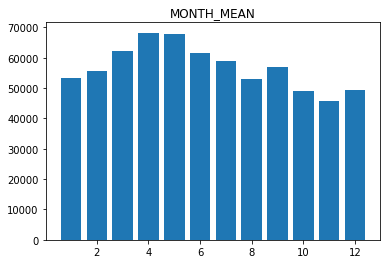

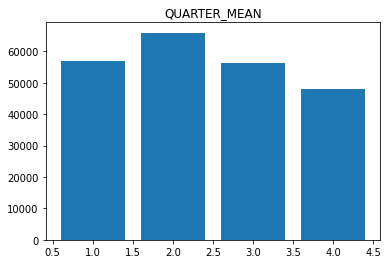

In [14]:
#for key, value in dict_ts.items():
mean_df = seasonal_means_extract(dataset = dict_ts_sequence['dataset'], 
                                 date_colname = dict_ts_sequence['date_colname'], 
                                 y_colname= dict_ts_sequence['y_colname'], 
                                 n_leads= dict_ts_sequence['n_leads'], 
                                 freq= dict_ts_sequence['freq'])
if dict_ts_sequence['freq'] == 12:
    print('SEASONALITIES')
    mean_df_distinct = mean_df[['MONTH','MONTH_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['MONTH'], mean_df_distinct['MONTH_MEAN'])
    plt.title('MONTH_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['QUARTER','QUARTER_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['QUARTER'], mean_df_distinct['QUARTER_MEAN'])
    plt.title('QUARTER_MEAN')
    plt.show()
else:
    print('SEASONALITIES')
    
    mean_df_distinct = mean_df[['DAY_OF_WEEK','DAY_OF_WEEK_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['DAY_OF_WEEK'], mean_df_distinct['DAY_OF_WEEK_MEAN'])
    plt.title('DAY_OF_WEEK_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['WEEK','WEEK_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['WEEK'], mean_df_distinct['WEEK_MEAN'])
    plt.title('WEEK_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['MONTH','MONTH_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['MONTH'], mean_df_distinct['MONTH_MEAN'])
    plt.title('MONTH_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['QUARTER','QUARTER_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['QUARTER'], mean_df_distinct['QUARTER_MEAN'])
    plt.title('QUARTER_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['WEEKLY_MONTHLY','WEEKLY_MONTHLY_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['WEEKLY_MONTHLY'], mean_df_distinct['WEEKLY_MONTHLY_MEAN'])
    plt.title('WEEKLY_MONTH_MEAN')
    plt.show()
    

In [15]:
### This function will be usefull to merge the seasonal means ont he final dataset
def merge_seasonal_features(dataset, seasonal_features):
    timeserie = dataset.copy()
    
    timeserie.index = pd.to_datetime(timeserie.index)

    timeserie.index.name = 'index'
    
    
    
    timeserie['MONTH'] = timeserie.index.month
    timeserie['QUARTER'] = timeserie.index.quarter
    timeserie['DAY_OF_MONTH'] = timeserie.index.day
    timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
    timeserie['WEEK'] = timeserie.index.week
    timeserie['MONTH'] = timeserie.index.month
    timeserie['QUARTER'] = timeserie.index.quarter
    timeserie['WEEKLY_MONTHLY'] = timeserie['DAY_OF_WEEK'].astype(str) + timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
    
    for feat in ['WEEK',
                 'MONTH',
                'QUARTER',
                'DAY_OF_MONTH',
                'DAY_OF_WEEK',
                'WEEKLY_MONTHLY']:
        if feat in seasonal_features.columns:
            seasonal_features_feat = seasonal_features[[feat, feat+'_MEAN']].drop_duplicates().reset_index(drop = True)
            timeserie = pd.merge(timeserie, seasonal_features_feat[[feat, feat+'_MEAN']], how = 'left', left_on = feat, right_on = feat)

            del timeserie[feat]
        else:
            try:
                del timeserie[feat]
            except:
                pass
            pass
    
    for col in timeserie.columns:
        dataset[col] = timeserie[col].values
    
    
    return dataset

### 2.3 Feature Extraction - Lag Features
In order to predict multiple steps ahead, it is imprtant to know that happened in the few steps before. We can use the lag features to capture the information from the past. Herem in our dataset, we are using the previous 14 periods to predict the next 24 periods. Therefore, the dimensions of each datapoint will shift from from 1D to 2D. From a vector to a matrix.

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, feat_str_at_end=True, feat_lag_str = 'TM', feat_lead_str = 'TP'):
    
    if feat_str_at_end == True:
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          if i < 10:
              name_i = '0' + str(i)
          else:
              name_i = str(i)
              
          names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'') +'_' + feat_lag_str + name_i) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
          else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + feat_lead_str + name_i) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
          agg.dropna(inplace=True)
    else:
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          names += [(feat_lag_str + '%d' % (i) + str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
          else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + feat_lead_str + name_i) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
          agg.dropna(inplace=True)
    return agg

Here, 'TM' means 'TIme Minus' and 'TP' means 'TIme Plus'. For example, TM1 means the value of the previous period, TM2 means the value of the period before the previous period, and so on. Now, we have a multi-target regression dataset.  
  
Now, we need to add the seasonal means to the lag features, so that the dataset becomes robust to the seasonality (in our dataset, the seasonality is yearly).

### 2.4 Feature Extraction - Fourier Terms

In [17]:
def extract_fourier_terms(dataset):
    
    #ts_copy = dataset[[date_colname]]
    dataset['sin365_2'] = np.sin(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['sin365_2'] = StandardScaler().fit_transform(dataset['sin365_2'].values.reshape(-1,1))
    
    dataset['sin365_4'] = np.sin(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['sin365_4'] = StandardScaler().fit_transform(dataset['sin365_4'].values.reshape(-1,1))
    
    dataset['cos365_2'] = np.cos(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['cos365_2'] = StandardScaler().fit_transform(dataset['cos365_2'].values.reshape(-1,1))
    
    dataset['cos365_4'] = np.cos(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['cos365_4'] = StandardScaler().fit_transform(dataset['cos365_4'].values.reshape(-1,1))
    
    dataset['tanh365_2'] = np.tanh(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['tanh365_2'] = StandardScaler().fit_transform(dataset['tanh365_2'].values.reshape(-1,1))
    
    dataset['tanh365_4'] = np.tanh(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['tanh365_4'] = StandardScaler().fit_transform(dataset['tanh365_4'].values.reshape(-1,1))
    
    return dataset

### 2.5 Merge Generated Features into a Final Dataset
We will merge the engineered features i.e. Seasonal Means, Lag Features, and Fourier Terms into a final dataset.

In [18]:
def dataprep_pipeline(ts_data, 
                      dict_ts_sequence, 
                      seasonal_features = True,
                      diff_trend = True,
                      exog = True,
                      fourier_terms = True):
    ####SCALING
    y_scaler_forecast = StandardScaler()
    ts_sequence_forecast = ts_data.copy()
    ts_sequence_forecast

    y_data = ts_sequence_forecast[[dict_ts_sequence['y_colname']]].copy()

    y_data = pd.DataFrame(y_scaler_forecast.fit_transform(y_data))
    y_data.columns = [dict_ts_sequence['y_colname']]
    for y_colname in y_data.columns:
        ts_sequence_forecast[y_colname] = y_data[y_colname].values

    y_colname = dict_ts_sequence['y_colname']
    ###CALCULATE SEASONAL MEANS
    if seasonal_features == True:
        seasonal_list = []
        all_cols = [dict_ts_sequence['date_colname'], dict_ts_sequence['y_colname']]

        ts_sequence_seasonal_feats_full = seasonal_means_extract(dataset = ts_data[all_cols], 
                                                         date_colname = dict_ts_sequence['date_colname'], 
                                                         y_colname= y_colname, 
                                                         n_leads= dict_ts_sequence['n_leads'], 
                                                         freq= dict_ts_sequence['freq'],
                                                          y_scaler_sequence = y_scaler_forecast)
        
        ts_sequence_seasonal_feats_full.index = pd.to_datetime(ts_data[dict_ts_sequence['date_colname']])
        del ts_sequence_seasonal_feats_full[dict_ts_sequence['date_colname']]
        del ts_sequence_seasonal_feats_full[y_colname]

    ts_sequence_forecast.index = pd.to_datetime(ts_sequence_forecast['DATE'])
    

    ts_sequence_supervised_full = series_to_supervised(ts_sequence_forecast[[y_colname]], 
                                              n_in=dict_ts_sequence['n_lags'], 
                                              n_out=1, 
                                              dropnan=True, 
                                              feat_str_at_end=True, 
                                              feat_lag_str = 'TM', 
                                              feat_lead_str = 'TP')
    
    ### MERGE SEASONAL MEANS
    if seasonal_features == True:
        ts_sequence_supervised_full = merge_seasonal_features(dataset = ts_sequence_supervised_full.copy(), 
                                                              seasonal_features = ts_sequence_seasonal_feats_full.copy())
        
        for col in ts_sequence_seasonal_feats_full.columns:
            if col in ts_sequence_supervised_full.columns:
                ts_sequence_supervised_full[col] = StandardScaler().fit_transform(ts_sequence_supervised_full[[col]]).ravel()

    ### DIFF TREND
    if diff_trend == True:

        ts_sequence_supervised_full['DIFF_' + y_colname] = StandardScaler().fit_transform(ts_sequence_supervised_full[y_colname].diff().fillna(0).values.reshape(-1,1))

        decomp = seasonal_decompose(ts_sequence_supervised_full[y_colname], model='additive', period = dict_ts_sequence['freq'], extrapolate_trend=1)
        ts_sequence_supervised_full['TREND_' + y_colname] = StandardScaler().fit_transform(decomp.trend.values.reshape(-1,1))
        #ts_sequence_supervised['SEASON'] = StandardScaler().fit_transform(decomp.seasonal.values.reshape(-1,1))

    ### EXOG
    if exog == True:
        exog_cols = []
        all_cols = [dict_ts_sequence['y_colname'], dict_ts_sequence['date_colname'], 'Date','date']
        for col in ts_sequence.columns.difference(all_cols):
            exog_cols.append(col)

        dict_ts_sequence_exog = ts_sequence[exog_cols]

        exog_scaler = StandardScaler()
        dict_ts_sequence_exog = pd.DataFrame(exog_scaler.fit_transform(dict_ts_sequence_exog),
                                             index = pd.to_datetime(ts_sequence[dict_ts_sequence['date_colname']]),
                                             columns = exog_cols)
        


        for col in dict_ts_sequence_exog.columns:
            ts_sequence_supervised_full = pd.merge(ts_sequence_supervised_full, 
                                                   dict_ts_sequence_exog[[col]],
                                                  how = 'left',
                                                  left_index = True,
                                                  right_index = True)
    
    return ts_sequence_supervised_full, y_scaler_forecast

In [19]:
ts_full, ts_sequence_train, ts_sequence_test = split_ts_train_test(ts = dict_ts_sequence['dataset_orig'].copy(),
                                                  date_colname = dict_ts_sequence['date_colname'],
                                                  y_colname_list = dict_ts_sequence['y_colname'],
                                                  n_leads = dict_ts_sequence['n_leads'])


diff_transformer_dict_train = {}
diff_transformer_dict_full = {}

log_transformer_dict_train = {}
log_transformer_dict_full = {}

y_colname =  dict_ts_sequence['y_colname']
log_transformer_full = TransformerLog()
diff_transformer_full = TransformerDiff()

if dict_ts_sequence['stabilize_variance'] == True:
    ts_full[y_colname] = log_transformer_full.fit_transform(ts_full[[y_colname]].values)
    log_transformer_dict_full[y_colname] = log_transformer_full
if dict_ts_sequence['stabilize_mean'] == True:
    ts_full[y_colname] = diff_transformer_full.fit_transform(ts_full[[y_colname]].values)
    diff_transformer_dict_full[y_colname] = diff_transformer_full
    
ts_full = ts_full.dropna()

log_transformer = TransformerLog()
diff_transformer = TransformerDiff()
if dict_ts_sequence['stabilize_variance'] == True:
    ts_sequence_train[y_colname] = log_transformer.fit_transform(ts_sequence_train[[y_colname]].values)
    log_transformer_dict_train[y_colname] = log_transformer
if dict_ts_sequence['stabilize_mean'] == True:
    ts_sequence_train[y_colname] = diff_transformer.fit_transform(ts_sequence_train[[y_colname]].values)
    diff_transformer_dict_train[y_colname] = diff_transformer
        
ts_sequence_train = ts_sequence_train.dropna()


dict_ts_sequence['diff_transformer_dict_full'] = diff_transformer_dict_full
dict_ts_sequence['log_transformer_dict_full'] = log_transformer_dict_full
ts_sequence_supervised_full, y_scaler_forecast = dataprep_pipeline(ts_full.copy(), 
                                                                  dict_ts_sequence, 
                                                                  seasonal_features = dict_ts_sequence['seasonal_features'],
                                                                  diff_trend = dict_ts_sequence['diff_trend'],
                                                                  exog = dict_ts_sequence['exog'],
                                                                  fourier_terms = dict_ts_sequence['fourier_terms'])

dict_ts_sequence['diff_transformer_dict_train'] = diff_transformer_dict_train
dict_ts_sequence['log_transformer_dict_train'] = log_transformer_dict_train
ts_sequence_supervised, y_scaler_sequence = dataprep_pipeline(ts_sequence_train.copy(), 
                                                              dict_ts_sequence, 
                                                              seasonal_features = dict_ts_sequence['seasonal_features'],
                                                              diff_trend = dict_ts_sequence['diff_trend'],
                                                              exog = dict_ts_sequence['exog'],
                                                              fourier_terms = dict_ts_sequence['fourier_terms'])

In [20]:
ts_sequence_supervised.columns

Index(['EASY_TM16', 'EASY_TM15', 'EASY_TM14', 'EASY_TM13', 'EASY_TM12',
       'EASY_TM11', 'EASY_TM10', 'EASY_TM09', 'EASY_TM08', 'EASY_TM07',
       'EASY_TM06', 'EASY_TM05', 'EASY_TM04', 'EASY_TM03', 'EASY_TM02',
       'EASY_TM01', 'EASY', 'MONTH_MEAN', 'QUARTER_MEAN'],
      dtype='object')

In [21]:
ts_sequence_supervised.head(1).T

DATE          2003-01-31
EASY_TM16      -1.326273
EASY_TM15      -1.513817
EASY_TM14      -1.675855
EASY_TM13      -1.794749
EASY_TM12      -1.561171
EASY_TM11      -1.502261
EASY_TM10      -0.669839
EASY_TM09      -0.490234
EASY_TM08      -0.870604
EASY_TM07      -0.707810
EASY_TM06      -0.825279
EASY_TM05      -1.579707
EASY_TM04      -1.396864
EASY_TM03      -1.395668
EASY_TM02      -1.454655
EASY_TM01      -1.754983
EASY           -1.183456
MONTH_MEAN     -0.477506
QUARTER_MEAN    0.070423

### 3 Convert Dataset from 2D Matrices to 3D Tensors

In [22]:
def prep_data_3d_arch1(data, y_colname_list, date_colname, n_leads):
    n_step = n_leads
    
    timeseries = data.copy()
    timeseries = timeseries[timeseries.columns.difference([date_colname])]
    
    xtimeseries = timeseries[timeseries.columns.difference([date_colname])]
    ytimeseries = timeseries[y_colname_list]
    
    feats = list(xtimeseries.columns)
    xlist = []
    ylist = []
    
    i=0
    for i in range(0, len(timeseries) - ((n_step*2)-1)):
        xlist.append([xtimeseries.iloc[i:i+n_step].values])
        ylist.append([ytimeseries.iloc[i+n_step:i+(n_step*2)][y_colname_list].values])
        
    xlist_T = np.array(xlist).reshape(len(xtimeseries)-((n_step*2)-1), n_step, len(xtimeseries.columns))
    ylist_T = np.array(ylist).reshape(len(ytimeseries)-((n_step*2)-1), n_step, len(y_colname_list))

    xlistTest = []
    i = 0
    for i in range(len(xtimeseries)-n_step, len(xtimeseries)-(n_step-1)):
        xlistTest.append([xtimeseries.iloc[i:i+n_step].values])
        
    xlistTest_T = np.array(xlistTest).reshape(1, n_step, len(xtimeseries.columns))

    xlist_T_all = xlist_T.copy()
    ylist_T_all = ylist_T.copy()
    xlistTest_T_all = xlistTest_T.copy()
    
    return xlist_T_all, ylist_T_all, xlistTest_T_all, feats

### 3.1 3D Train Test Split

In [23]:
x_train_sequence, y_train_sequence, x_test_sequence, feats = prep_data_3d_arch1(data=ts_sequence_supervised.copy(),
                                                                                y_colname_list=[dict_ts_sequence['y_colname']],
                                                                                date_colname=dict_ts_sequence['date_colname'],
                                                                                n_leads=dict_ts_sequence['n_leads'])

In [24]:
print(x_train_sequence.shape, y_train_sequence.shape)

dict_explain_tensor = {}
ijk = 0 
for val in x_train_sequence.shape:
    if ijk == 0:
        dict_explain_tensor[val] = 'Number of rows (Time occurences)'
    elif ijk == 1:
        dict_explain_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif ijk == 2:
        dict_explain_tensor[val] = 'Number of columns (Features)'
    print(val, dict_explain_tensor[val])
    ijk += 1

(136, 24, 19) (136, 24, 1)
136 Number of rows (Time occurences)
24 Sequence length - Number of steps to forecasts (n_leads)
19 Number of columns (Features)


In [25]:
print(x_test_sequence.shape)

(1, 24, 19)


### 3.2 3D Forecasting Dataset

In [26]:
x_train_full, y_train_full, x_forecast, feats = prep_data_3d_arch1(data = ts_sequence_supervised_full.copy(),
                                                                    y_colname_list = [dict_ts_sequence['y_colname']],
                                                                    date_colname = dict_ts_sequence['date_colname'],
                                                                    n_leads = dict_ts_sequence['n_leads'])

In [27]:
print(x_train_full.shape, y_train_full.shape)
dict_explain_full_tensor = {}
ijk = 0 
for val in x_train_full.shape:
    if ijk == 0:
        dict_explain_full_tensor[val] = 'Number of rows (Time occurences)'
    elif ijk == 1:
        dict_explain_full_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif ijk == 2:
        dict_explain_full_tensor[val] = 'Number of columns (Features)'
    print(val, dict_explain_full_tensor[val])
    ijk += 1

(160, 24, 19) (160, 24, 1)
160 Number of rows (Time occurences)
24 Sequence length - Number of steps to forecasts (n_leads)
19 Number of columns (Features)


## 4 Performance Metrics (RdR Score)
The proposed RdR metric use: <br>
R: Naïve Random Walk <br>
d: Dynamic Time Warping <br>
R: Root Mean Squared Error <br>

The proposed RdR score technic will mainly answer three questions: <br>
#1 How can we take into account the shape similarity of a time series? : <br>
Answer: Dynamic Time Warping <br>

#2 How can we know if we should use our forecasting model or not? : <br>
Answer: Is it better or worst than a Naïve Random Walk? How Much ? (Well... also depends on your business goals here !) <br>

#3 How can we take into account the errors? : <br>
Answer: Root Mean Squared Error (RMSE) <br> 

0 = Performance same as a random walk model <br>
1 = Performance is perfect <br>
< 0 = Performance is worst than a random walk model <br>

Further reading: <br>
<https://medium.com/@dave.cote.msc/rdr-score-metric-for-evaluating-time-series-forecasting-models-1c23f92f80e7>

In [28]:
scorer_benchmark = RdR_scorer()

## 5 Bidirectional LSTM Model

In [29]:
class PrintDot(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('.', end='')

### 5.1 BiLSTM Architecture

In [30]:
input_dim = int(x_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])

def create_BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=input_dim,
                                 return_sequences=False,
                                 kernel_initializer='glorot_uniform',
                                 activation='tanh',
                                 )))
    model.add(Dense(output_dim, activation='linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])
    
    return model

model = create_BiLSTM()    

### 5.2 BiLSTM Model Training

In [31]:
monitor_label = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor_label, patience=10)
history = model.fit(x_train_sequence, y_train_sequence,
                    epochs=1000,
                    batch_size=60,
                    validation_data=(x_train_full[-dict_ts_sequence['n_leads']:, :, :],
                                     y_train_full[-dict_ts_sequence['n_leads']:, :, :]),
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping, PrintDot()])

...

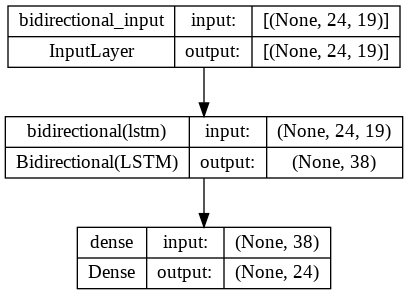

In [32]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [33]:
def plot_learning_curve(history, monitor_label='val_loss'):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    min_vec = []
    for i in range(len(hist)):
        if i == 0:
            min_vec.append(hist[[monitor_label]].iloc[i, :].values[0])
        else:
            if hist[[monitor_label]].iloc[i, :].values[0] < np.min(min_vec):
                min_vec.append(hist[[monitor_label]].iloc[i, :].values[0])
            else:
                min_vec.append(np.min(min_vec))
    
    hist['best_from_start'] = min_vec
    hist['improved'] = np.where(hist['best_from_start'] == hist[monitor_label], 1, 0)
    
    best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
    
    plt.figure(figsize=(18, 9))
    plt.plot(hist[monitor_label], label=monitor_label)
    
    try:
        plt.plot(hist['loss'], label='loss')
    except:
        pass
    
    plt.scatter(hist[hist['improved'] == 1]['epoch'], hist[hist['improved'] == 1][monitor_label], color='green', label='improved')
    plt.legend()
    plt.title('Learning curve'
              '\n' + 'best epoch:' + str(best_epoch) + '(' + str(round(np.min(hist[monitor_label]), 3)) + ')')

Max epoch: 277
Best epoch: 267


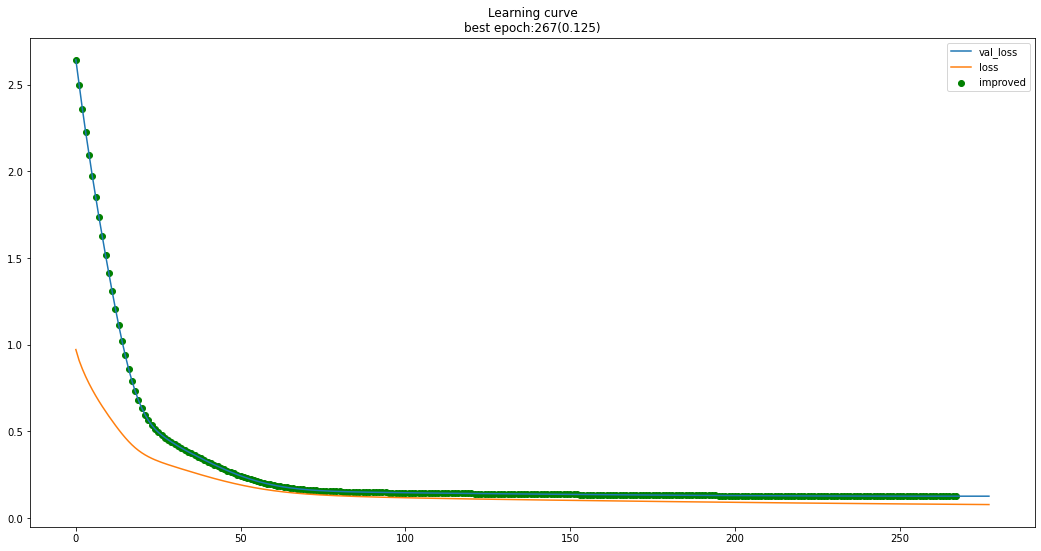

In [34]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('Max epoch:', max_epoch)
print('Best epoch:', best_epoch)

### 5.3 BiLSTM Model Validation

In [35]:
pred_all = pd.DataFrame(model.predict(x_test_sequence)).T

1/1 [==============================] - 1s 749ms/step


In [36]:
def inverse_forecast(y_scaler, dict_ts, pred_df):
    pred_df = pd.DataFrame(y_scaler.inverse_transform(pred_df))
    pred_df.columns = ['Y_PRED']
    
    if dict_ts_sequence['stabilize_mean'] == True:
        pred_df['Y_PRED'] = dict_ts_sequence['diff_transformer_dict_train'][dict_ts['y_colname']].forecast_transform(pred_df[['Y_PRED']].values)
    if dict_ts_sequence['stabilize_variance'] == True:
        pred_df['Y_PRED'] = dict_ts_sequence['log_transformer_dict_train'][dict_ts['y_colname']].inverse_transform(pred_df[['Y_PRED']].values)
 
    return pred_df

In [37]:
def get_feat_for_scoring(ts, y_scaler, dict_ts, pred_df, model_name):
    
    ts_orig = y_scaler.inverse_transform(ts[dict_ts['y_colname']].values.reshape(-1,1))
    ts_orig = pd.DataFrame(ts_orig, index = ts.index, columns = [dict_ts['y_colname']])
    
    pred_df = inverse_forecast(y_scaler, dict_ts, pred_df)

    y_colname = dict_ts['y_colname']
    n_steps = dict_ts['n_leads']

    y_true = ts.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values.reshape(-1,1)
    y_true = pd.DataFrame(y_true, index = pd.to_datetime(ts.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), columns = [dict_ts['y_colname']])
    
    y_pred = pred_df.copy()
    y_pred = pd.DataFrame(y_pred.values.ravel(), index = pd.to_datetime(ts.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), columns = ['Y_PRED'])

    freq = dict_ts['freq']    
  
    return ts, y_colname, n_steps, y_true, y_pred, model_name, freq

In [38]:
ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'BiLSTM')

average_ensemble_model = []
average_ensemble_model.append(y_pred)

In [39]:
scorer_benchmark.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)

1970-02-28 00:00:00.000000222 1972-01-31 00:00:00.000000222


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)


In [40]:
scorer_benchmark.get_df_viz()

DTW          RMSE  RdR_SCORE  MODEL_NAME
0  21910.770652   7112.950336   0.519818      BiLSTM
1  59099.430044  12063.620641   0.000000  RandomWalk

In [41]:
print(scorer_benchmark.get_rdr_interpretation())

GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)


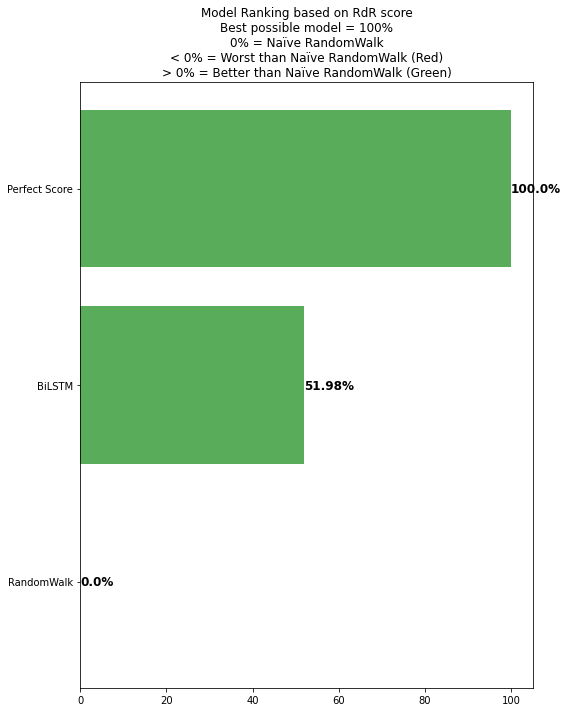

In [42]:
scorer_benchmark.plot_rdr_rank()

In [43]:
def get_pred_dates(freq, X_pred, date_colname, n_leads):
    #ts_sequence_train.index = pd.to_datetime(ts_sequence_train[date_colname])
    if freq == 12:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=1)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(months=i) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
    
    elif freq == 52:
        print(X_pred.index)
        print(max(X_pred.index))
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(weeks=1) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(weeks=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 4:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=3)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(months=i*3) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
    
    elif freq == 2:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=6)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(years=i*6) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq == 1:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(years=1)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(years=i) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq >= 250 and freq <= 368:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(days=1) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(days=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
            
    elif freq == 1638:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=60)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*60) ])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
            
    elif freq == 3276:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=30) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*30) ])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
    
    elif freq == 6552:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=15) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*15)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 9828:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=10)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*10)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq == 19656:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=5)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*5)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 98280:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=1)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    return X_pred_date

In [44]:
def plot_results(ts_train, ts_full, pred_df, y_scaler, forecast, y_scaler_forecast, dict_ts):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(pd.to_datetime(ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['date_colname']]),
            ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['y_colname']].values, label='PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),
            pred_df.values.ravel(), label='PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
            ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values, label = 'TRUE_TEST')
    plt.title('Validation: True vs MultiStep Forecast')
    plt.legend()

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),  
        pred_df.values.ravel())
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
        ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values)
    plt.title('Validation (Zoomed): True vs MultiStep Forecast')
    plt.legend()

    fig, ax = plt.subplots(figsize = (12,8))
    #ax.plot(pd.to_datetime(ts_train.index), 
            #ts_train[dict_ts['y_colname']].values.reshape(-1,1))
    ax.plot(pd.to_datetime(ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['date_colname']]),  
            ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['y_colname']].values, label = 'HISTORICAL')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),  
            pred_df.values.ravel(), label = 'PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
            ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values, label = 'TRUE_TEST')
    ax.plot(forecast.index, 
            forecast['Y_PRED'].values.ravel(), label = 'FORECAST')
    plt.title('MultiStep Forecast - ' + model_name)
    plt.legend()

### 5.4 BiLSTM Model Forecasting

In [45]:
monitor_label = 'loss'
early_stopping = EarlyStopping(monitor=monitor_label, patience=100)

model = create_BiLSTM()

history = model.fit(x_train_full,
                    y_train_full,
                    epochs=best_epoch*2,
                    batch_size=100,
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping, PrintDot()])

pred_fscaled = pd.DataFrame(model.predict(x_forecast))
pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] = pred_forecast[col].astype(float)
    
ts_sequence_train.index = pd.to_datetime(ts_sequence_train[dict_ts_sequence['date_colname']])
ts_sequence.index = pd.to_datetime(ts_sequence[dict_ts_sequence['date_colname']])

x_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = x_pred_date.index

average_ensemble_model_forecast = []
average_ensemble_model_forecast.append(pred_forecast)

1/1 [==============================] - 1s 659ms/step


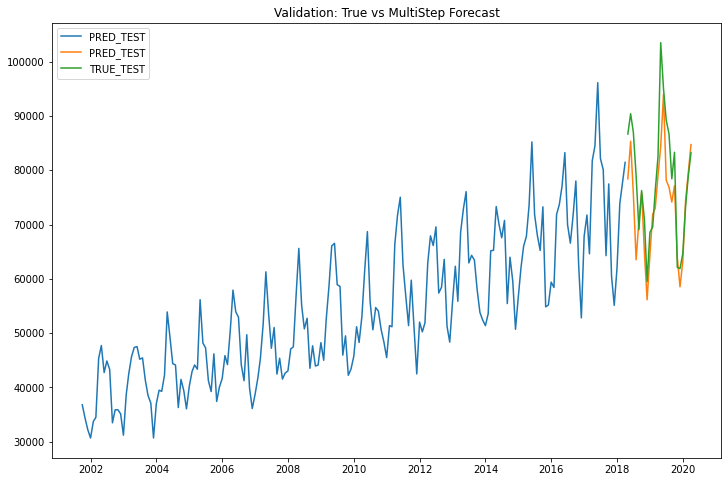

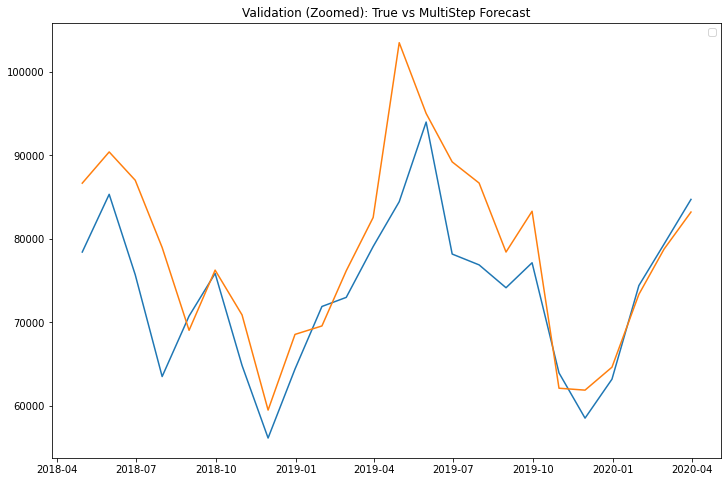

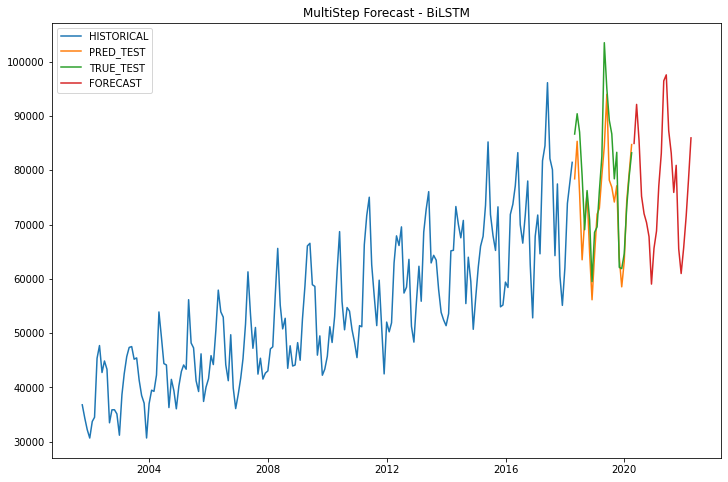

In [46]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

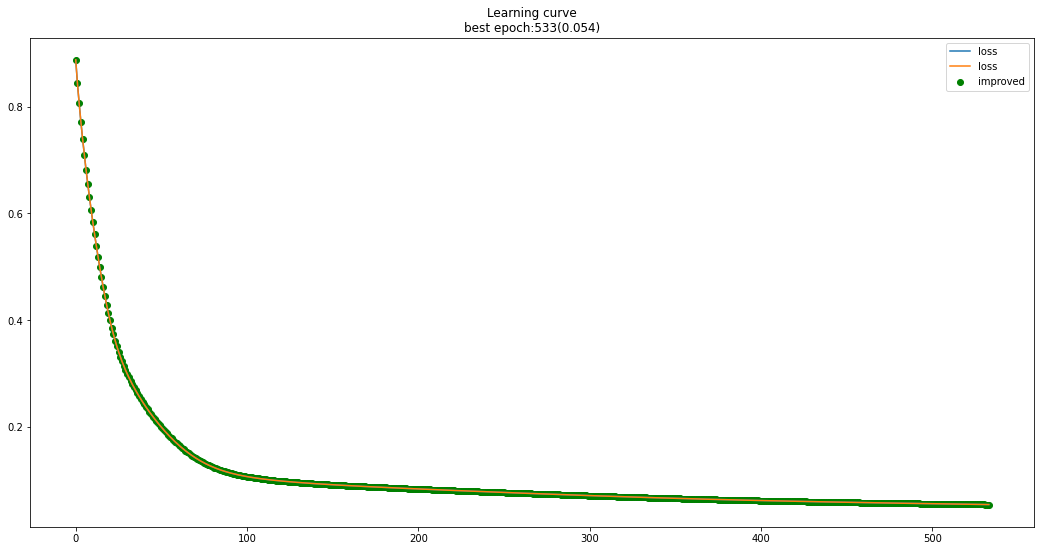

In [47]:
plot_learning_curve(history, monitor_label='loss')

## 6 Seq2Seq Model

### 6.1 Seq2Seq Architecture
Seq2seq Model is a combination of two models: Encoder and Decoder. The encoder model takes the input sequence and converts it into a vector. The decoder model takes the vector from the encoder and converts it into the output sequence. Seq2seq is mainly used to transform one sequence to another sequence i.e. time-series forecasting, machine translation, or text summarization can be some of the proper use cases of seq2seq.

In [48]:
# NR
input_dim = int(x_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])
n_samples = len(x_train_sequence)

In [49]:
input_dim = int(x_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])
n_samples = len(x_train_sequence)

def create_seq2seq():
    model = Sequential()
    
    # Encoder (first LSTM layer)
    model.add(LSTM(units=input_dim, return_sequences=False, activation = 'tanh'))
    model.add(Dense(150, activation="relu"))
    
    # using RepeatVector to copy N copies of Encoder output (last time step) as Decoder N inputs
    model.add(RepeatVector(output_dim))
    
    # Decoder (second LSTM layer)
    model.add(LSTM(units=input_dim, activation = 'tanh', return_sequences=True))
    
    # TimeDistributed layer to ensure consistency betweeb Dense Layer and Decoder LSTM layer
    model.add(TimeDistributed(Dense(output_dim, activation="linear")))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    
    return model

model = create_seq2seq()

### 6.2 Seq2Seq Model Training

In [50]:
monitor_label = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor_label, patience=50)
history = model.fit(x_train_sequence,
                    y_train_sequence,
                    epochs=1000,
                    batch_size=24,
                    validation_data=(x_train_full[-24:, :, :],
                                     y_train_full[-24:, :, :]),
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping, PrintDot()])

.....

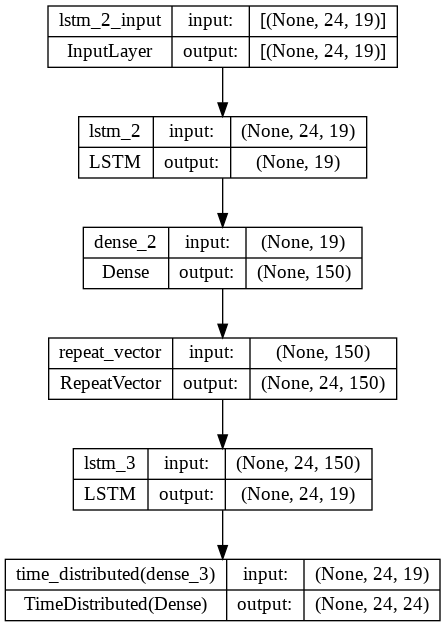

In [51]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 470


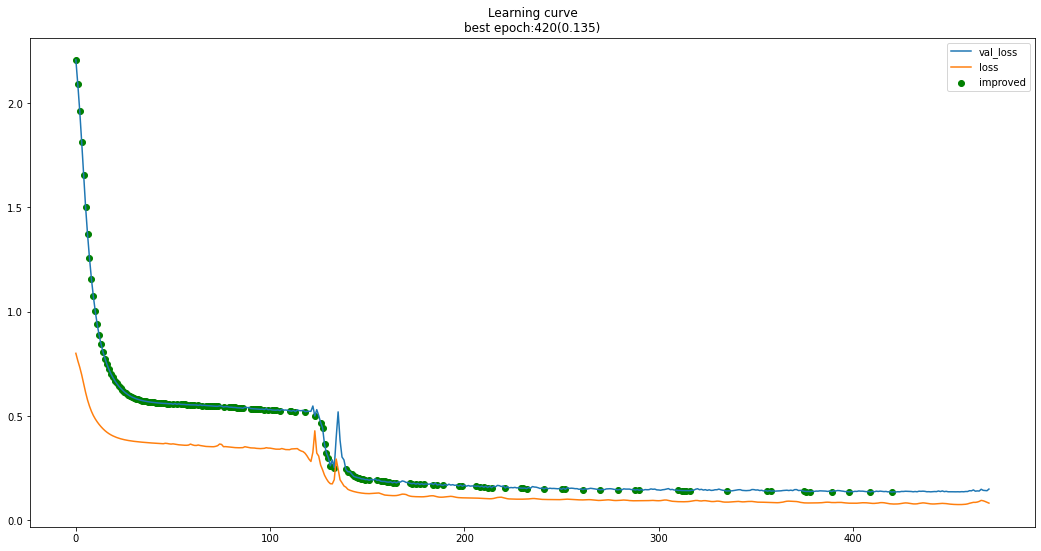

In [52]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

### 6.3 Seq2Seq Model Validation

In [53]:
pred_scaled = pd.DataFrame(model.predict(x_test_sequence)[0, :].T)
pred_all = pd.DataFrame(np.mean(pred_scaled.T, axis=1))
pred_all.columns = ['Y_PRED']

1/1 [==============================] - 1s 699ms/step


In [54]:
scorer_seq2seq = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts=ts_sequence.copy(),
                                                                                     y_scaler=y_scaler_sequence,
                                                                                     dict_ts=dict_ts_sequence.copy(),
                                                                                     pred_df=pred_all.copy(),
                                                                                     model_name='Seq2Seq')
average_ensemble_model.append(y_pred)

scorer_seq2seq.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name=model_name, freq=freq)
scorer_benchmark.add_rdr(scorer_seq2seq)

2020-04-30 00:00:00 2022-03-31 00:00:00


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


DTW          RMSE  RdR_SCORE  MODEL_NAME
0  21910.770652   7112.950336   0.519818      BiLSTM
1  59099.430044  12063.620641   0.000000  RandomWalk
2  24605.420990   6402.221406   0.526478     Seq2Seq

In [55]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)'

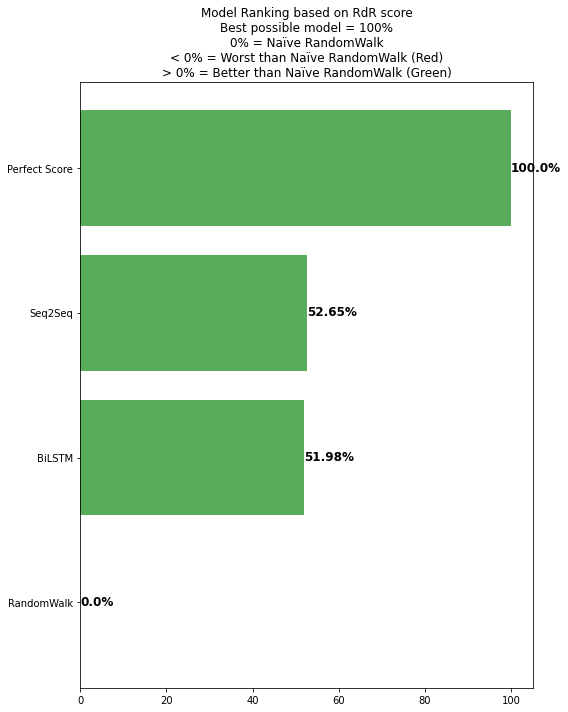

In [56]:
scorer_benchmark.plot_rdr_rank()

### 6.4 Seq2Seq Model Forecasting

In [57]:
monitor_label = 'loss'
early_stopping = EarlyStopping(monitor=monitor_label, patience=25)

model = create_seq2seq()

history = model.fit(x_train_full,
                    y_train_full,
                    epochs=best_epoch*2,
                    batch_size=24,
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping, PrintDot()])

pred_fscaled = pd.DataFrame(model.predict(x_forecast)[0, :].T)
pred_forecast = pd.DataFrame(np.mean(pred_fscaled.T, axis=1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] = pred_forecast[col].astype(float)

x_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = x_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

1/1 [==============================] - 1s 698ms/step


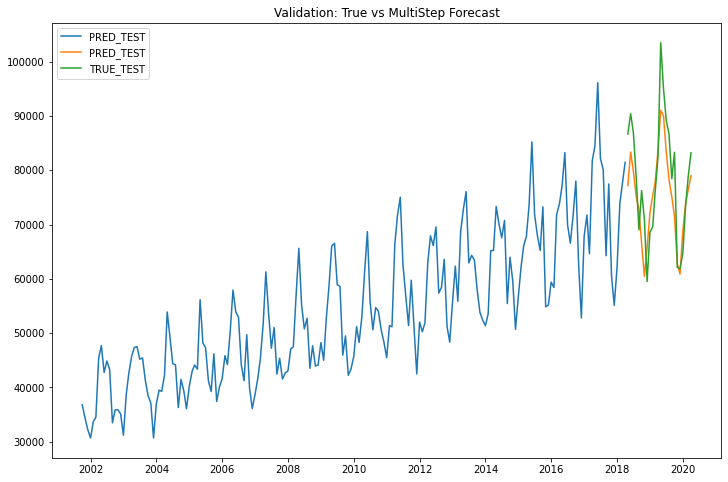

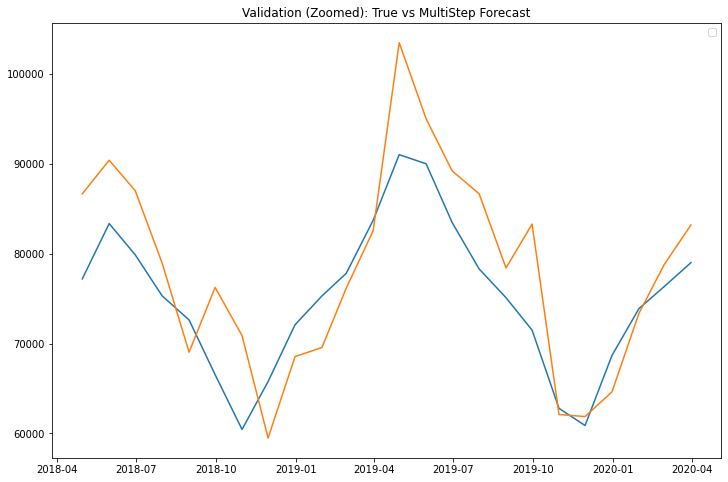

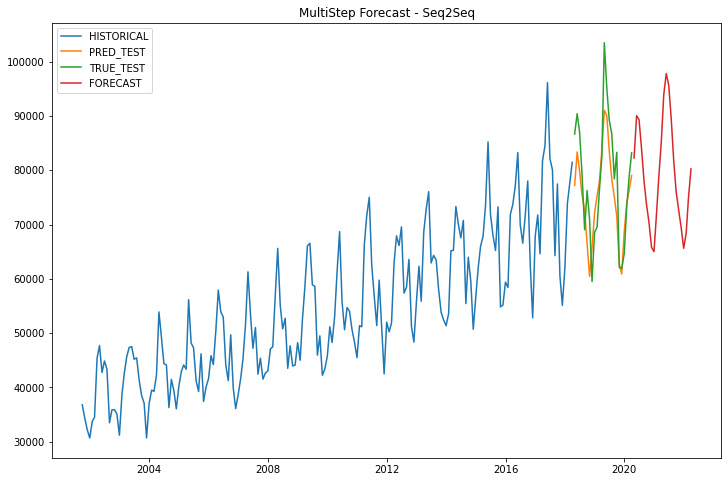

In [58]:
plot_results(ts_sequence_train,
             ts_sequence,
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all),
             y_scaler_sequence,
             pred_forecast,
             y_scaler_forecast,
             dict_ts_sequence)

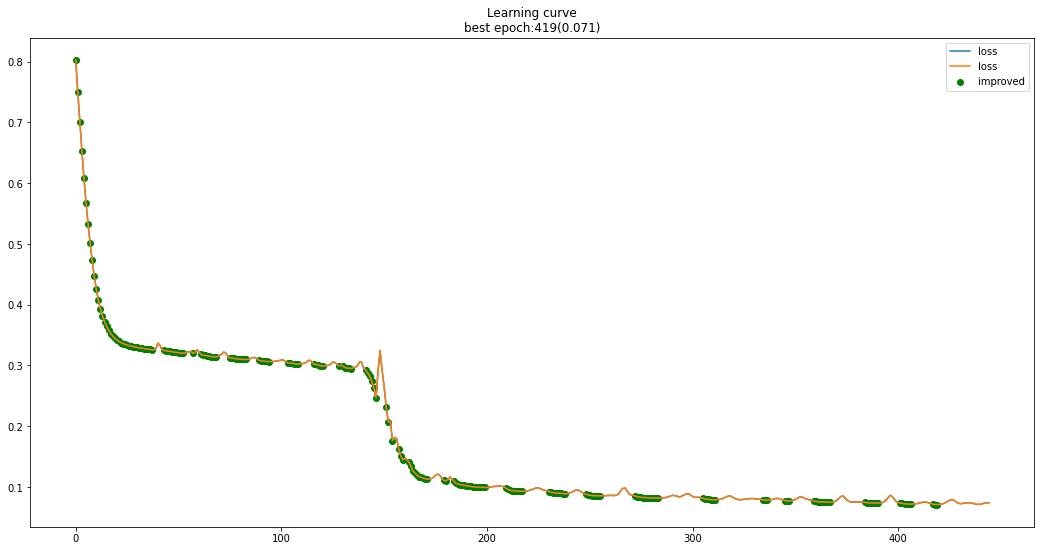

In [59]:
plot_learning_curve(history, monitor_label='loss')

In [60]:
print('input_dim :', input_dim)
print('output_dim :', output_dim)

input_dim : 19
output_dim : 24


## 7 CNN - BiLSTM Model [TODO]

### 7.1 CNN - BiLSTM Architecture

In [74]:
X_train_cnn = x_train_sequence.reshape(x_train_sequence.shape[0],
                                    x_train_sequence.shape[1],
                                    x_train_sequence.shape[2],
                                    1)

X_train_full_cnn = x_train_full.reshape(x_train_full.shape[0],
                                    x_train_full.shape[1],
                                    x_train_full.shape[2],
                                    1)

def create_cnn_BiLSTM():
    model = Sequential() 
    model.add(TimeDistributed(Conv1D(filters=256, kernel_size=4, activation='tanh')))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='tanh')))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='tanh')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(GlobalMaxPool1D())) 
    model.add(Bidirectional(LSTM(input_dim, return_sequences=True, activation = 'tanh')))
    model.add(TimeDistributed(Dense(output_dim, activation = 'linear')))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=opt)
    
    return model

model = create_cnn_BiLSTM()

### 7.2 CNN - BiLSTM Model Training

In [75]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)
history = model.fit(X_train_cnn, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 6, 
                    validation_data = (X_train_full_cnn[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

...

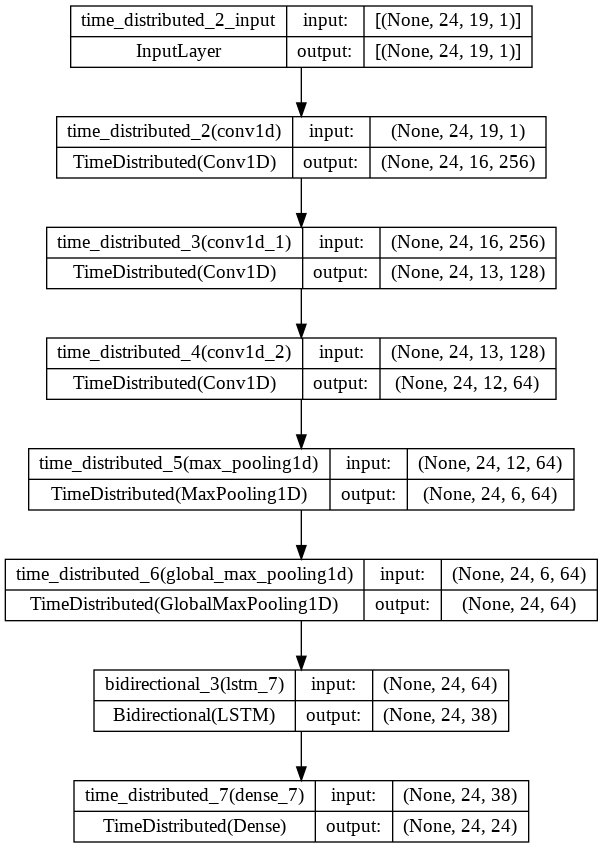

In [76]:
plot_model(model, show_shapes=True, show_layer_names=True)   

max epoch : 205


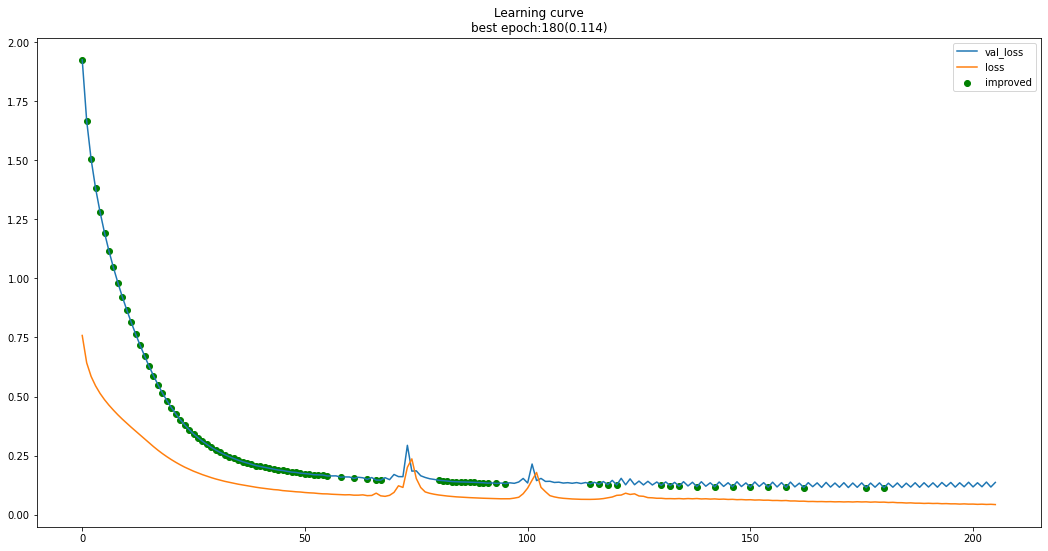

In [77]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

### 7.3 CNN - BiLSTM Model Validation

In [78]:
x_test_cnn = x_test_sequence.reshape(x_test_sequence.shape[0],
                                     x_test_sequence.shape[1],
                                     x_test_sequence.shape[2],
                                     1)

pred_scaled = pd.DataFrame(np.mean(model.predict(x_test_cnn), axis=0))
pred_all = pd.DataFrame(np.mean(pred_scaled, axis=1))  
pred_all.columns = ['Y_PRED']

1/1 [==============================] - 1s 817ms/step


In [79]:
scorer_cnnlstm = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'CNN-BiLSTM')
average_ensemble_model.append(y_pred)

scorer_cnnlstm.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name=model_name, freq=freq)
print(scorer_cnnlstm.score())
scorer_benchmark.add_rdr(scorer_cnnlstm)

2020-04-30 00:00:00 2022-03-31 00:00:00
0.5954630859779184


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


DTW          RMSE  RdR_SCORE  MODEL_NAME
0  21910.770652   7112.950336   0.519818      BiLSTM
1  59099.430044  12063.620641   0.000000  RandomWalk
2  24605.420990   6402.221406   0.526478     Seq2Seq
3  22482.519890   5171.134577   0.595463  CNN-BiLSTM

In [80]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)'

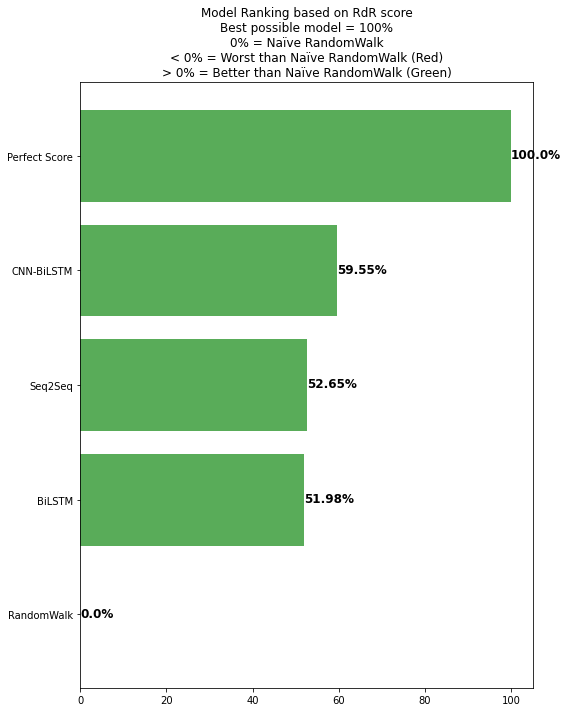

In [81]:
scorer_benchmark.plot_rdr_rank()

### 7.4 CNN - BiLSTM Model Forecasting

In [82]:
X_train_full_cnn = x_train_full.reshape(x_train_full.shape[0],
                                        x_train_full.shape[1],
                                        x_train_full.shape[2],
                                        1)

X_forecast_cnn = x_forecast.reshape(x_forecast.shape[0],
                                    x_forecast.shape[1],
                                    x_forecast.shape[2],
                                    1)

monitor_label = 'loss'
early_stopping = EarlyStopping(monitor=monitor_label, patience=25)

model = create_cnn_BiLSTM()

history = model.fit(X_train_full_cnn,
                    y_train_full,
                    epochs=best_epoch,
                    batch_size=6,
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping, PrintDot()])

pred_fscaled = pd.DataFrame(np.mean(model.predict(X_forecast_cnn), axis = 0))
pred_forecast = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

..

1/1 [==============================] - 1s 780ms/step


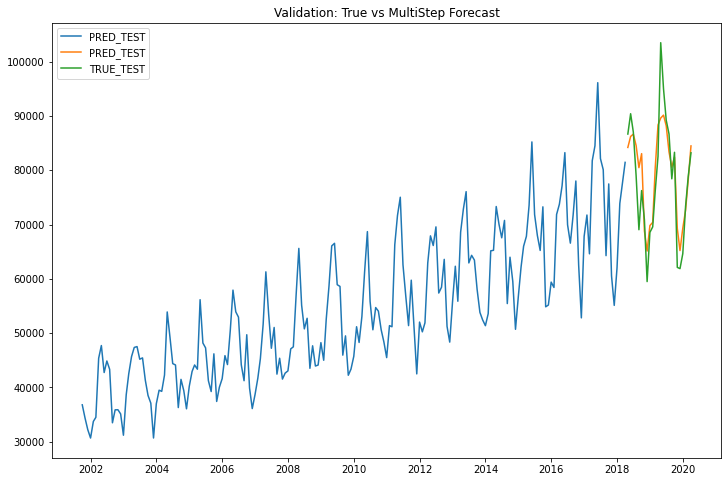

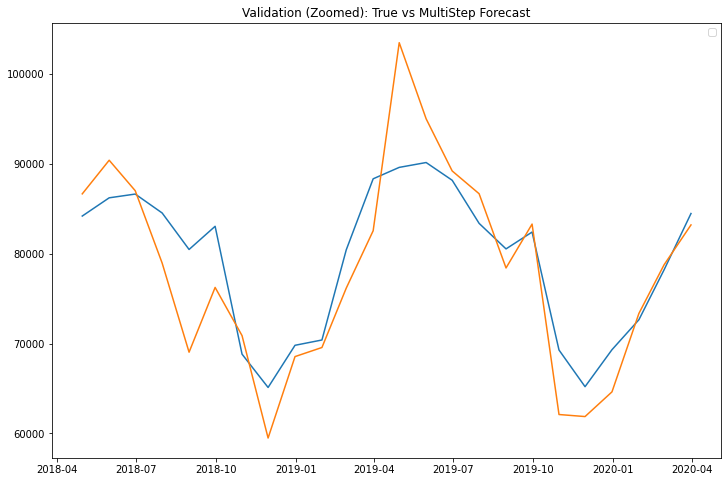

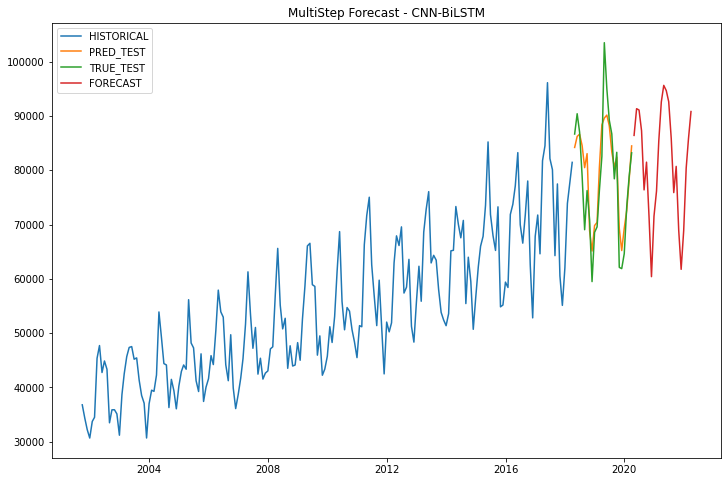

In [83]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

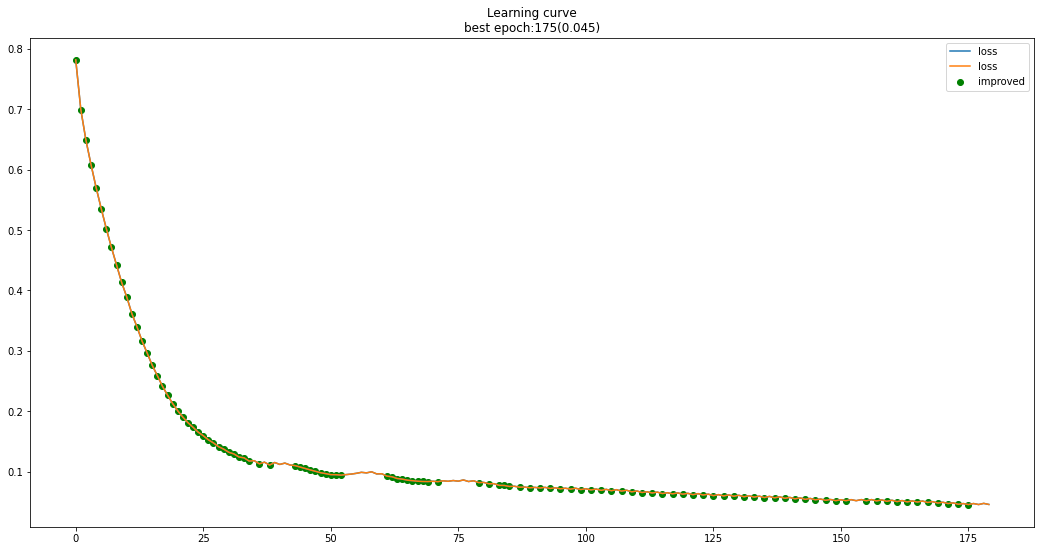

In [84]:
plot_learning_curve(history, 'loss')

## 8 TCN - BiLSTM Model

### 8.1 TCN - BiLSTM Architecture

In [85]:
def create_tcn():
    i = Input(shape=(x_train_sequence.shape[1], x_train_sequence.shape[2]))
    m = TCN(nb_filters=32,
            kernel_size=16,
            nb_stacks=4,
            dilations=(2, 4, 8, 16, 32, 64),
            padding='causal',
            use_skip_connections=True,
            dropout_rate=0.0,
            activation='tanh',
            kernel_initializer='glorot_uniform',
            use_batch_norm=False,
            use_layer_norm=False,
            use_weight_norm=False,
            return_sequences=True)(i)
    
    m = Bidirectional(LSTM(input_dim, return_sequences=False, activation='tanh'))(m)
    m = Dense(y_train_sequence.shape[1], activation='linear')(m)
    
    model = Model(inputs=[i], outputs=[m])
    model.summary()
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=opt)
    
    return model

model = create_tcn()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 19)]          0         
                                                                 
 tcn_1 (TCN)                 (None, 24, 32)            781952    
                                                                 
 bidirectional_5 (Bidirectio  (None, 38)               7904      
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 24)                936       
                                                                 
Total params: 790,792
Trainable params: 790,792
Non-trainable params: 0
_________________________________________________________________


### 8.2 TCN - BiLSTM Model Training

In [86]:
monitor_label = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor_label, patience=25)

history = model.fit(x_train_sequence,
                    y_train_sequence,
                    epochs=450,
                    batch_size=4,
                    validation_data=(x_train_full[-24:, :, :],
                                     y_train_full[-24:, :, :]),
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping, PrintDot()])

...

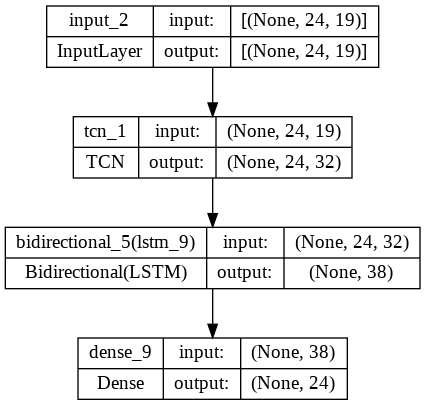

In [87]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 216


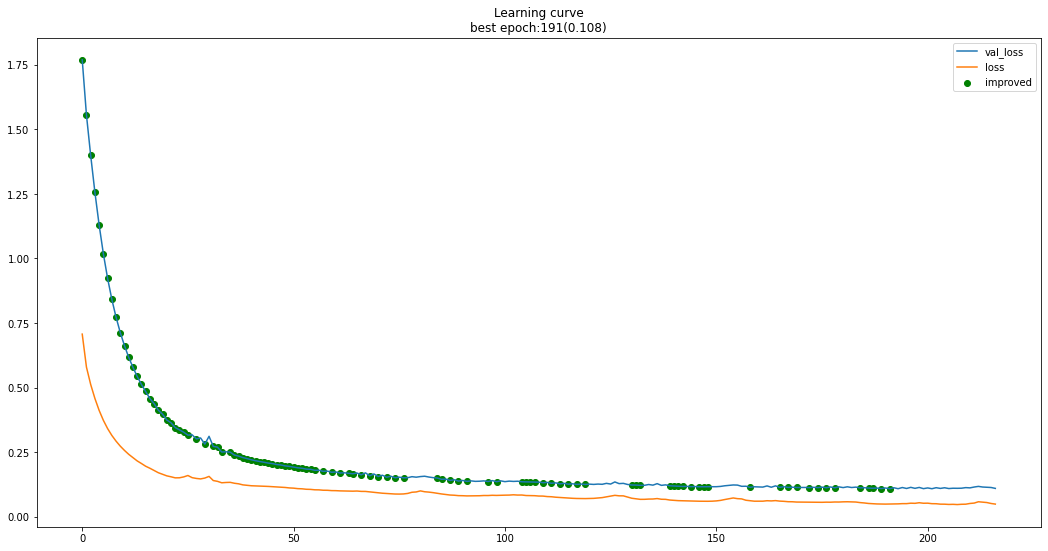

In [88]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

### 8.3 TCN - BiLSTM Model Validation

In [89]:
pred_scaled = model.predict(x_test_sequence).ravel()
pred_scaled

1/1 [==============================] - 2s 2s/step


array([1.7254508 , 2.3769135 , 1.9294378 , 1.1226475 , 0.86777204,
       1.9751182 , 1.2187786 , 0.4787428 , 1.2929107 , 1.0890749 ,
       1.3339367 , 1.54405   , 2.3126466 , 2.7536175 , 2.2599373 ,
       1.921282  , 1.4333614 , 1.8377856 , 1.1501253 , 0.5189339 ,
       1.1298614 , 1.5042565 , 1.6658715 , 1.8474488 ], dtype=float32)

In [90]:
pred_all = pd.DataFrame(pred_scaled)
pred_all.columns = ['Y_PRED']

In [91]:
scorer_seq2seq = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'TCN-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_seq2seq.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
scorer_benchmark.add_rdr(scorer_seq2seq)

2020-04-30 00:00:00 2022-03-31 00:00:00


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


DTW          RMSE  RdR_SCORE  MODEL_NAME
0  21910.770652   7112.950336   0.519818      BiLSTM
1  59099.430044  12063.620641   0.000000  RandomWalk
2  24605.420990   6402.221406   0.526478     Seq2Seq
3  22482.519890   5171.134577   0.595463  CNN-BiLSTM
4  23444.513717   6635.842410   0.526617  TCN-BiLSTM

In [92]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)'

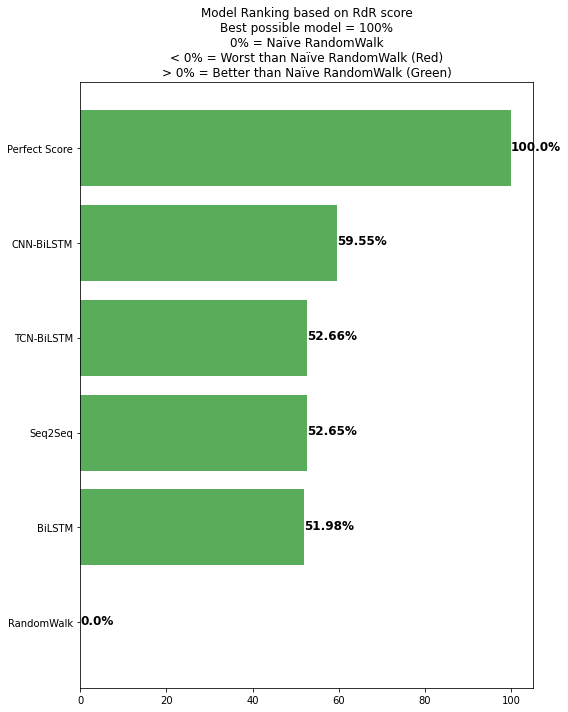

In [93]:
scorer_benchmark.plot_rdr_rank()

### 8.4 TCN - BiLSTM Model Forecasting

In [94]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)

model = create_tcn()

history = model.fit(X_train_full_cnn, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size =4, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

pred_fscaled = model.predict(x_test_sequence).ravel()
pred_forecast = pd.DataFrame(pred_fscaled)

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 24, 19)]          0         
                                                                 
 tcn_2 (TCN)                 (None, 24, 32)            781952    
                                                                 
 bidirectional_6 (Bidirectio  (None, 38)               7904      
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 24)                936       
                                                                 
Total params: 790,792
Trainable params: 790,792
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 2s 2s/step


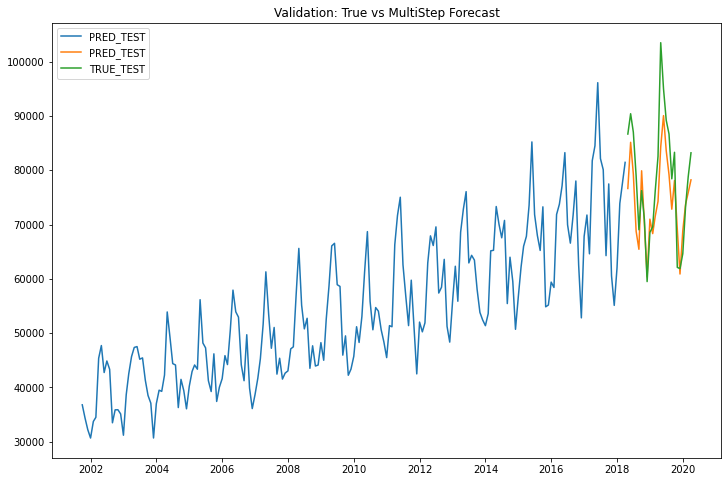

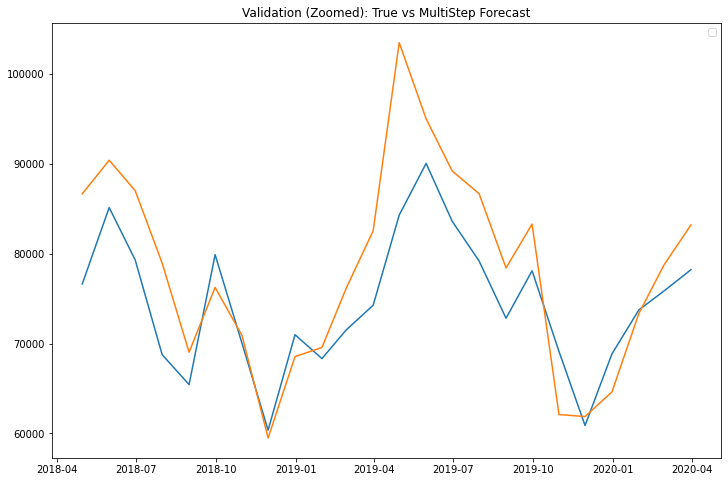

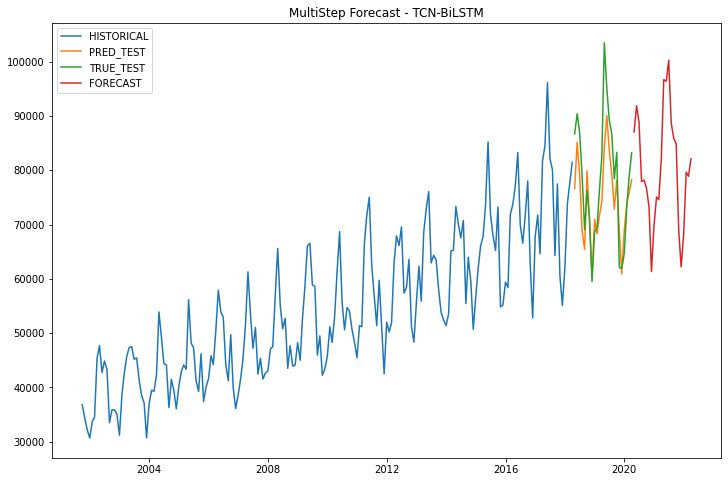

In [95]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

## 9 MDN - BiLSTM Model

### 9.1 MDN - BiLSTM Architecture

In [96]:
n_mixtures = 5
def create_mdn_BiLSTM(n_mixtures = n_mixtures):
    
    model = Sequential()

    model.add(Bidirectional(LSTM(units=input_dim, 
                                 return_sequences=False, 
                                 kernel_initializer = 'normal',
                                 activation = 'tanh'
                                 )))
    model.add(Dense(250, activation = 'tanh'))
    model.add(MDN(output_dim, n_mixtures))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=get_mixture_loss_func(output_dim, n_mixtures), optimizer=opt)
    return model

model = create_mdn_BiLSTM()

### 9.2 MDN - BiLSTM Model Training

In [97]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=18)
history = model.fit(x_train_sequence, 
                    y_train_sequence,
                    epochs=450, 
                    batch_size = 100, 
                    validation_data = (x_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

....

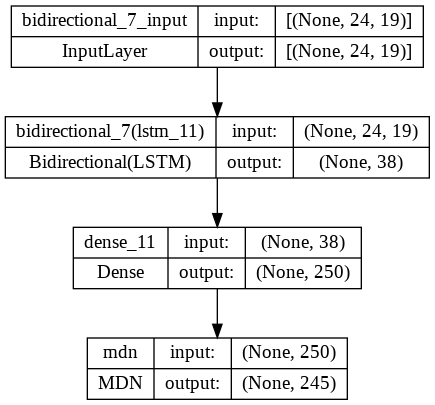

In [98]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 355


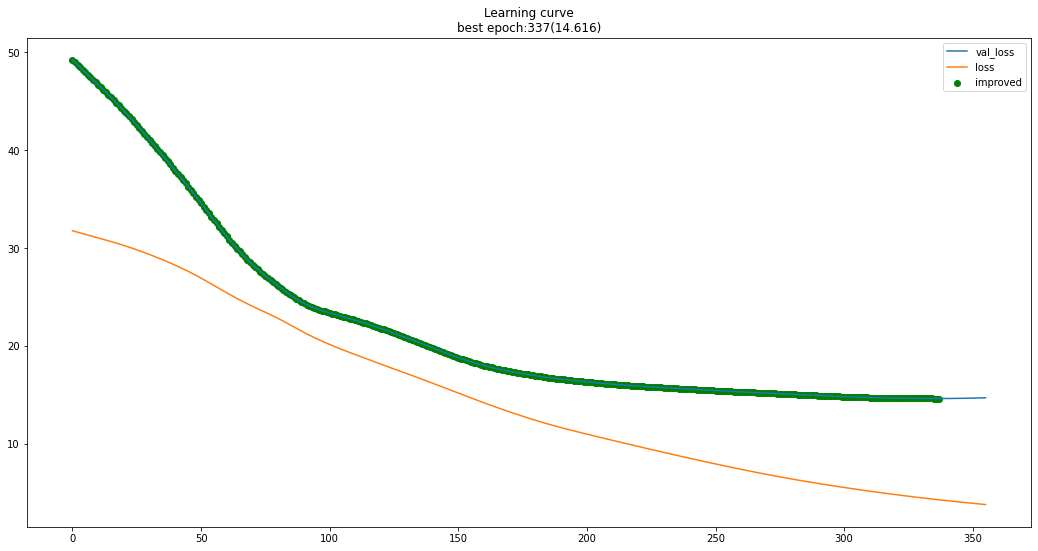

In [99]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

### 9.3 MDN - BiLSTM Model Validation

In [100]:
pred_scaled = model.predict(x_test_sequence)

1/1 [==============================] - 1s 730ms/step


In [101]:
pred_dist = []
for i in range(0, 10001):
    y_samples = np.apply_along_axis(sample_from_output, 1, pred_scaled, output_dim, n_mixtures, temp=1.0)
    pred_dist.append(y_samples[0].ravel())

pred_dist = pd.DataFrame(pred_dist)  

pred_scaled = pd.DataFrame(np.mean(pred_dist, axis = 0))
pred_all =  pred_scaled.copy()

pred_all.columns = ['Y_PRED']

In [102]:
scorer_mdnstm = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'MDN-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_mdnstm.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
print(scorer_mdnstm.score())
scorer_benchmark.add_rdr(scorer_mdnstm)

2020-04-30 00:00:00 2022-03-31 00:00:00
0.3701363334018936


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


DTW          RMSE  RdR_SCORE  MODEL_NAME
0  21910.770652   7112.950336   0.519818      BiLSTM
1  59099.430044  12063.620641   0.000000  RandomWalk
2  24605.420990   6402.221406   0.526478     Seq2Seq
3  22482.519890   5171.134577   0.595463  CNN-BiLSTM
4  23444.513717   6635.842410   0.526617  TCN-BiLSTM
5  33656.092557   8326.851534   0.370136  MDN-BiLSTM

In [103]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)'

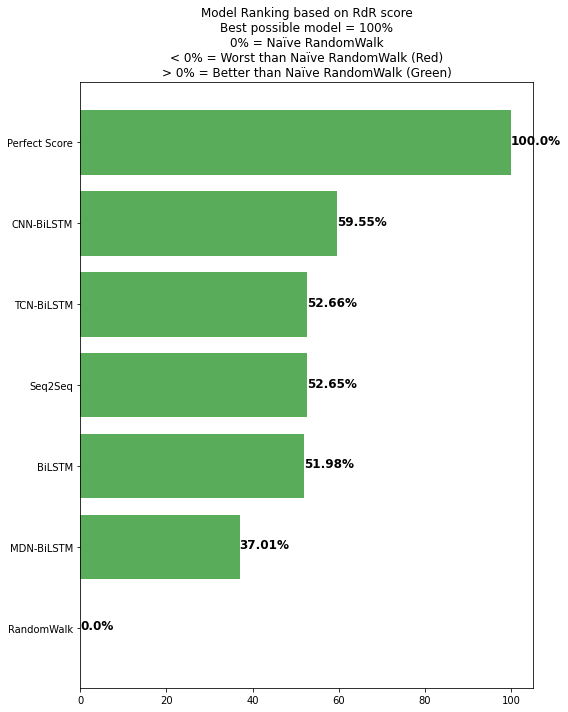

In [104]:
scorer_benchmark.plot_rdr_rank()

### 9.4 MDN - BiLSTM Model Forecasting

In [105]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)

model = create_mdn_BiLSTM()

history = model.fit(x_train_full, 
                    y_train_full,
                    epochs=best_epoch*2, 
                    batch_size = 100, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

.......

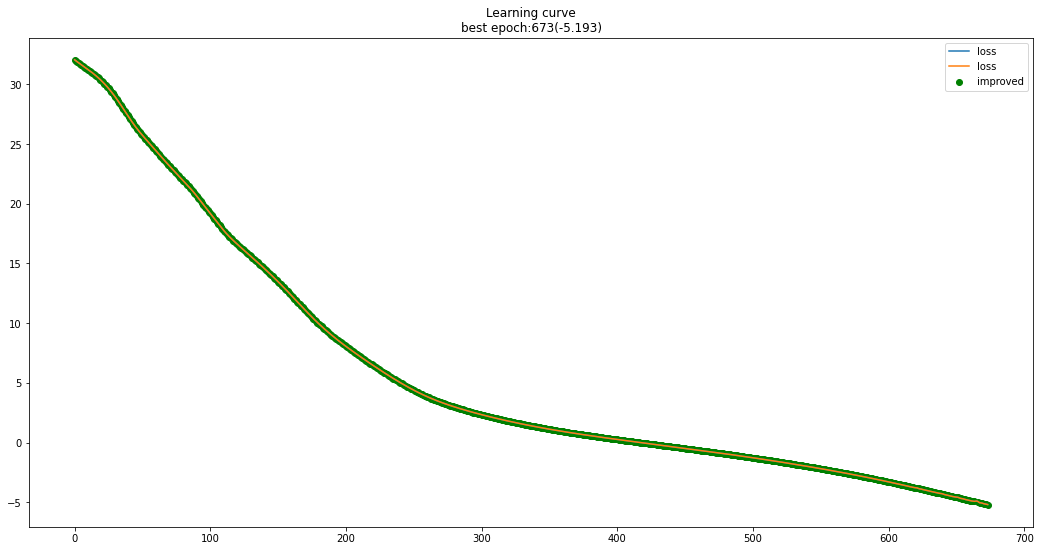

In [106]:
plot_learning_curve(history, 'loss')

In [108]:
pred_fscaled = model.predict(x_forecast)
        
pred_dist = []
for i in range(0, 10001):
    y_samples = np.apply_along_axis(sample_from_output, 1, pred_fscaled, output_dim, n_mixtures, temp=1.0)
    pred_dist.append(y_samples[0].ravel())

pred_dist = pd.DataFrame(pred_dist)  

pred_fscaled = pd.DataFrame(np.mean(pred_dist, axis = 0))
pred_forecast =  pred_fscaled.copy()

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

1/1 [==============================] - 1s 747ms/step


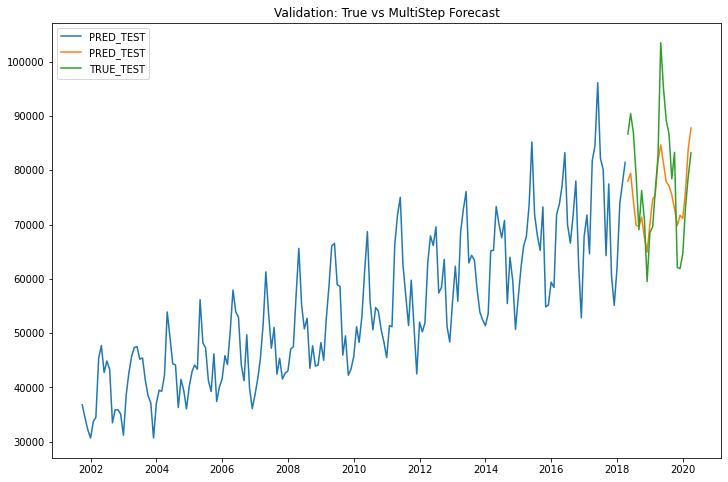

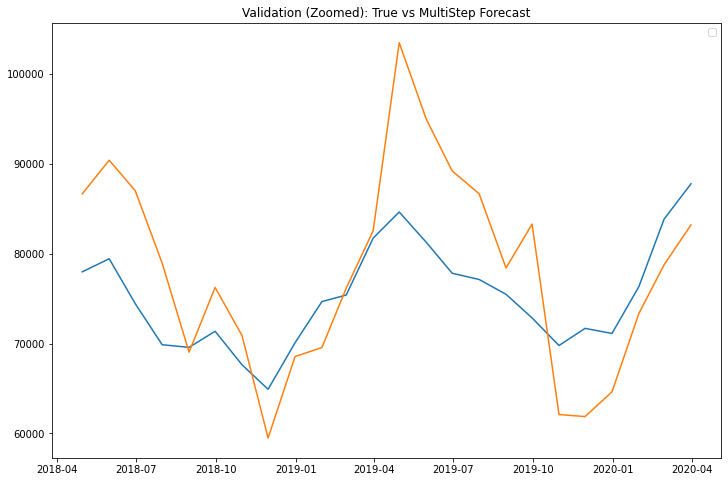

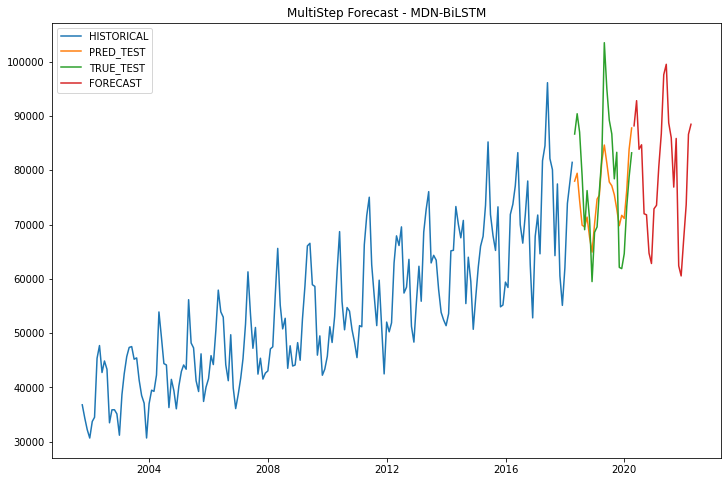

In [109]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

## 10 Attention - BiLSTM Model

### 10.1 Attention - BiLSTM Architecture

In [110]:
def create_attention_BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=input_dim, 
                                 return_sequences=True, 
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 )))
    model.add(SeqSelfAttention(attention_activation = 'linear'))
    model.add(TimeDistributed(Dense(units=output_dim, activation = None)))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)#, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    return model

model = create_attention_BiLSTM()

### 10.2 Attention - BiLSTM Model Training

In [111]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=12)
history = model.fit(x_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 6, 
                    validation_data = (x_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

..

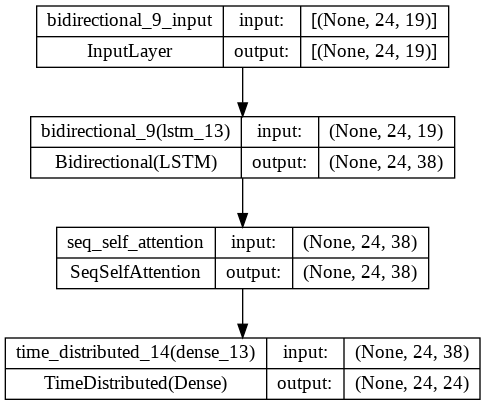

In [112]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 131


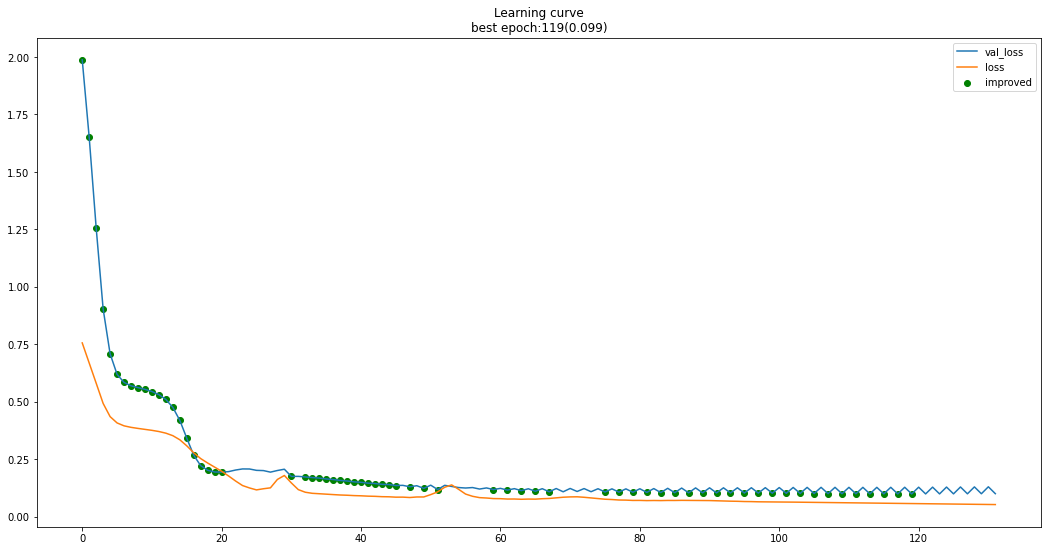

In [113]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

## 10.3 Attention - BiLSTM Model Validation

In [114]:
pred_scaled = pd.DataFrame(np.mean(model.predict(x_test_sequence), axis = 0))
pred_all = pd.DataFrame(np.mean(pred_scaled, axis = 1))
pred_all.columns = ['Y_PRED']

1/1 [==============================] - 1s 784ms/step


In [115]:
scorer_att = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'Attention-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_att.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)

scorer_benchmark.add_rdr(scorer_att)

2020-04-30 00:00:00 2022-03-31 00:00:00


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


DTW          RMSE  RdR_SCORE        MODEL_NAME
0  21910.770652   7112.950336   0.519818            BiLSTM
1  59099.430044  12063.620641   0.000000        RandomWalk
2  24605.420990   6402.221406   0.526478           Seq2Seq
3  22482.519890   5171.134577   0.595463        CNN-BiLSTM
4  23444.513717   6635.842410   0.526617        TCN-BiLSTM
5  33656.092557   8326.851534   0.370136        MDN-BiLSTM
6  24894.147765   6100.647626   0.536534  Attention-BiLSTM

In [116]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)'

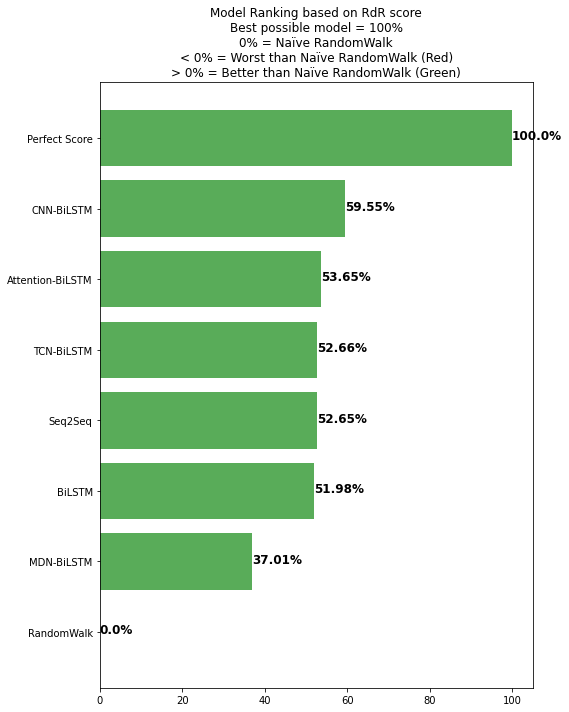

In [117]:
scorer_benchmark.plot_rdr_rank()

### 10.4 Attention - BiLSTM Model Forecasting

In [118]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=16)

model = create_attention_BiLSTM()

history = model.fit(x_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 6, 
                    
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

#pred_fscaled = pd.DataFrame(model.predict(X_forecast))
#pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_fscaled = pd.DataFrame(np.mean(model.predict(x_forecast), axis = 0))
pred_fscaled = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_fscaled.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

1/1 [==============================] - 1s 779ms/step


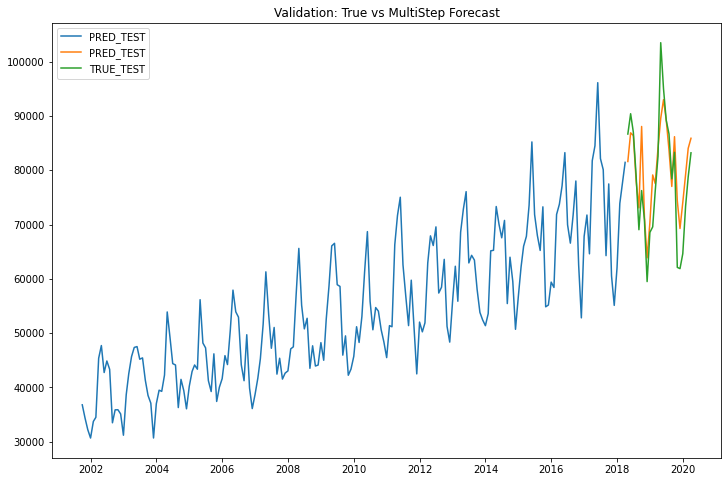

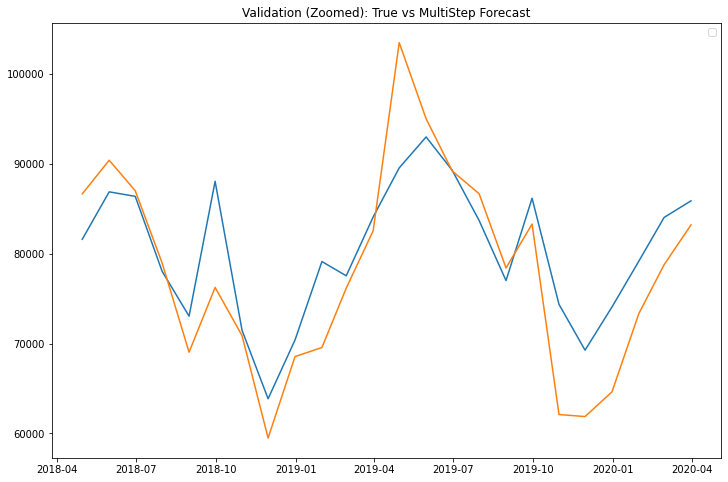

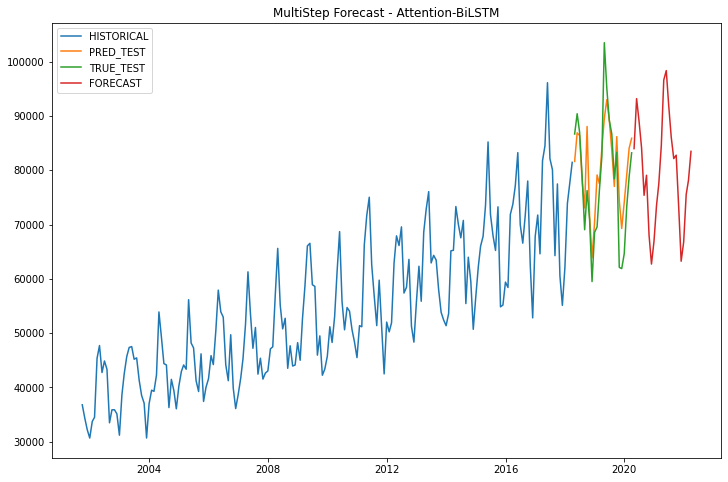

In [119]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

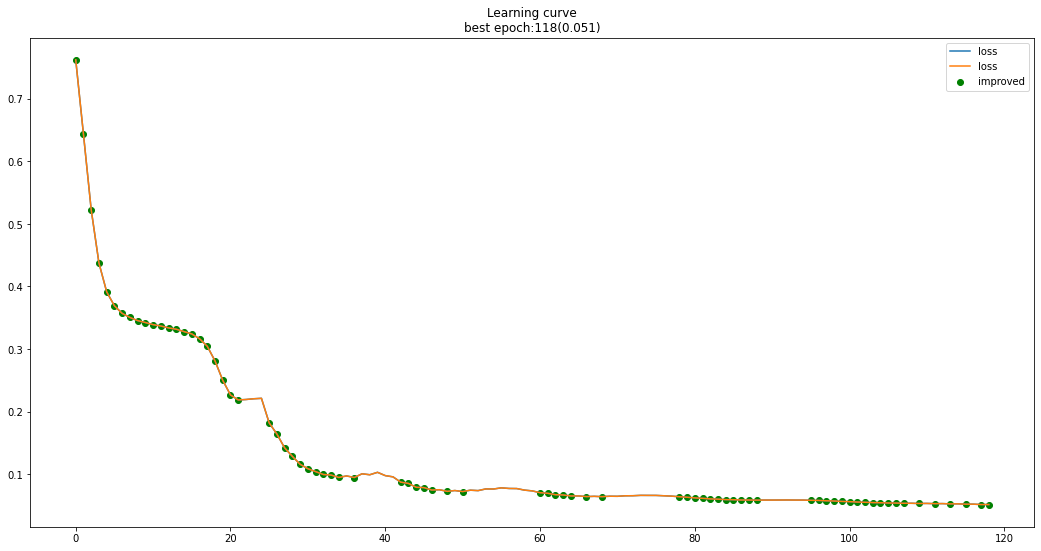

In [120]:
plot_learning_curve(history, 'loss')

## 11 Seq2Seq Attention Model

### 11.1 Seq2Seq Attention Architecture

In [125]:
def create_seq2seqAtt():

    input_train = Input(shape=(x_train_sequence.shape[1], x_train_sequence.shape[2]))
    output_train = Input(shape=(y_train_sequence.shape[1], y_train_sequence.shape[2]))    

    encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(48, activation='tanh', 
                                                           dropout=0.2, 
                                                           recurrent_dropout=0.2, 
                                                           return_state=True, 
                                                           return_sequences=True)(input_train)
    
    decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
    
    decoder_stack_h = LSTM(48, activation='tanh', 
                           dropout=0.2, 
                           recurrent_dropout=0.2,
                           return_state=False, 
                           return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
    
    attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = Activation('softmax')(attention)
    
    context = dot([attention, encoder_stack_h], axes=[2,1])
    
    decoder_combined_context = concatenate([context, decoder_stack_h])
    
    out = TimeDistributed(Dense(y_train_sequence.shape[2]))(decoder_combined_context)
    model = Model(inputs=input_train, outputs=out)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    
    return model

model = create_seq2seqAtt()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 24, 19)]     0           []                               
                                                                                                  
 lstm_19 (LSTM)                 [(None, 24, 48),     13056       ['input_8[0][0]']                
                                 (None, 48),                                                      
                                 (None, 48)]                                                      
                                                                                                  
 repeat_vector_4 (RepeatVector)  (None, 24, 48)      0           ['lstm_19[0][1]']                
                                                                                            

### 11.2 Seq2Seq Attention Model Training

In [126]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)
history = model.fit(x_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 24, 
                    validation_data = (x_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

...

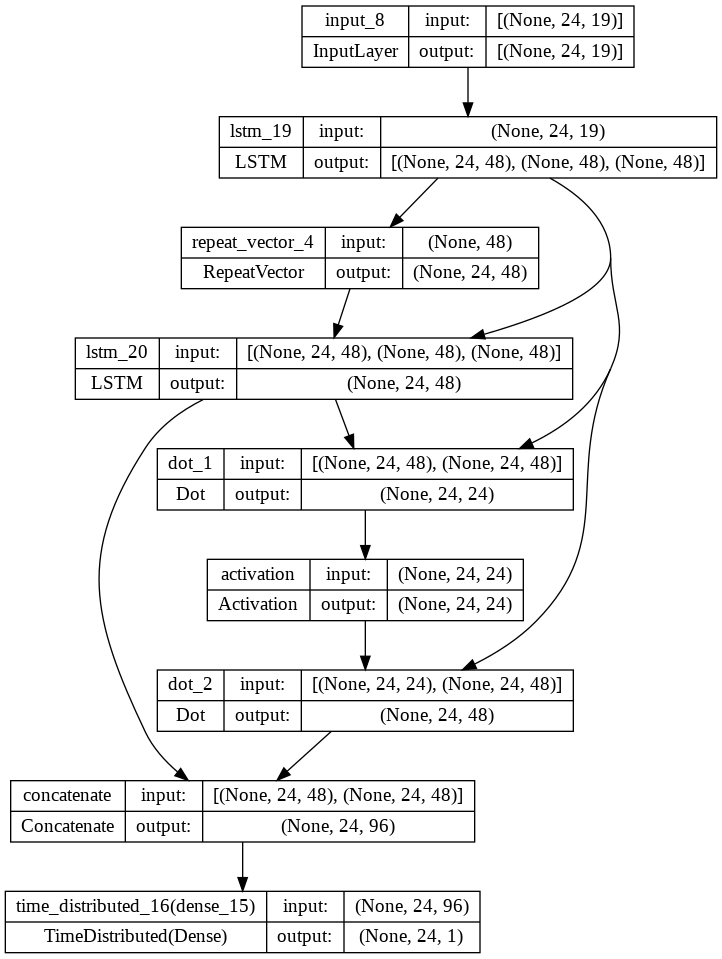

In [127]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 214


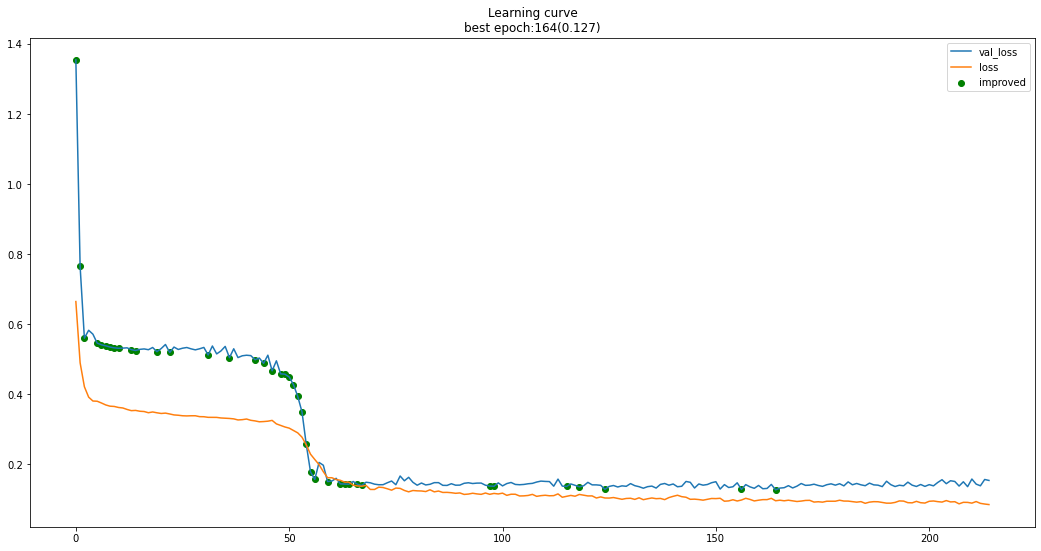

In [128]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

### 11.3 Seq2Seq Attention Model Validation

In [129]:
pred_scaled = pd.DataFrame(model.predict(x_test_sequence)[0,:].T)
pred_all = pd.DataFrame(np.mean(pred_scaled.T, axis = 1))
pred_all.columns = ['Y_PRED']

1/1 [==============================] - 0s 435ms/step


In [130]:
scorer_s2satt = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'Seq2SeqAttention-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_s2satt.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)

scorer_benchmark.add_rdr(scorer_s2satt)

2020-04-30 00:00:00 2022-03-31 00:00:00


DTW          RMSE  RdR_SCORE               MODEL_NAME
0  21910.770652   7112.950336   0.519818                   BiLSTM
1  59099.430044  12063.620641   0.000000               RandomWalk
2  24605.420990   6402.221406   0.526478                  Seq2Seq
3  22482.519890   5171.134577   0.595463               CNN-BiLSTM
4  23444.513717   6635.842410   0.526617               TCN-BiLSTM
5  33656.092557   8326.851534   0.370136               MDN-BiLSTM
6  24894.147765   6100.647626   0.536534         Attention-BiLSTM
7  18525.716709   5673.077172   0.608135  Seq2SeqAttention-BiLSTM

In [131]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)'

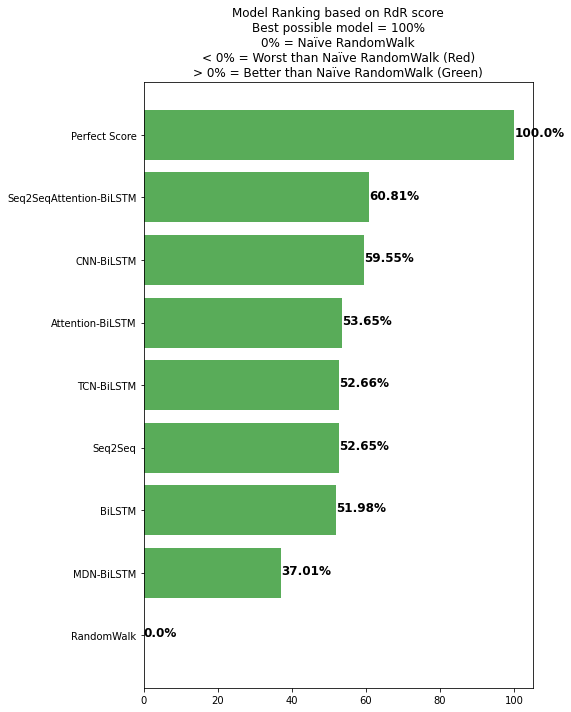

In [132]:
scorer_benchmark.plot_rdr_rank()

### 11.4 Seq2Seq Attention Model Forecasting

In [133]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)

model = create_seq2seq()

history = model.fit(x_train_full, 
                    y_train_full,
                    epochs=best_epoch*2, 
                    batch_size = 24,#36, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

pred_fscaled = pd.DataFrame(model.predict(x_forecast)[0,:].T)
pred_forecast = pd.DataFrame(np.mean(pred_fscaled.T, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)

    
X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

1/1 [==============================] - 1s 715ms/step


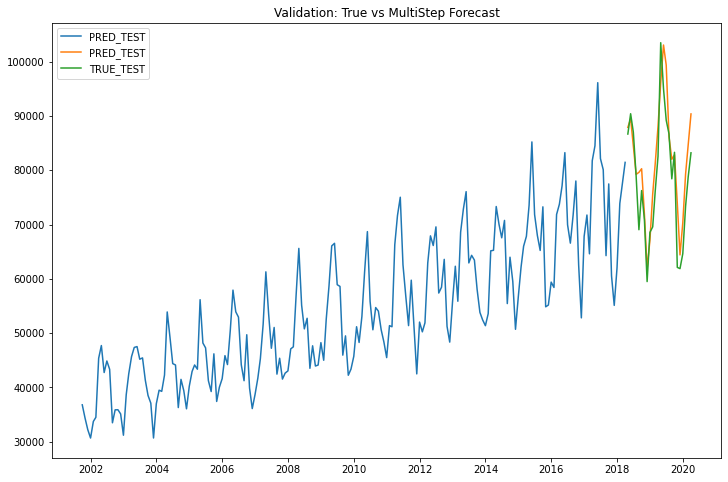

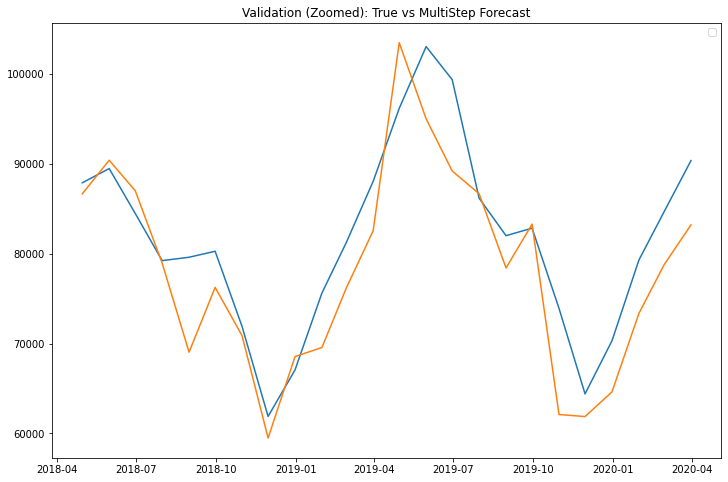

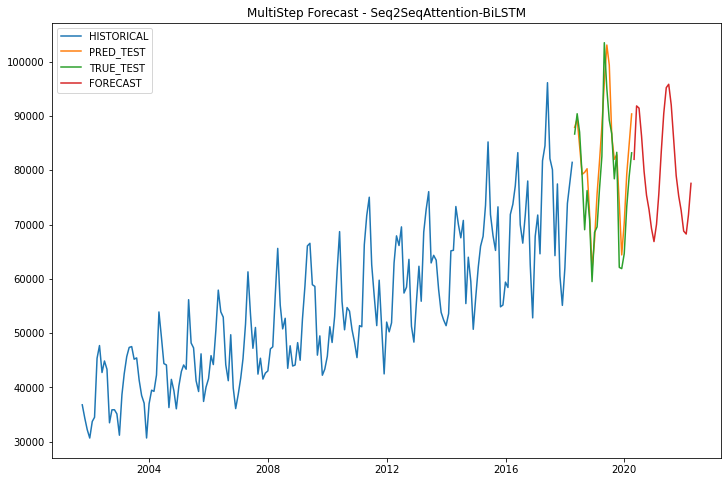

In [134]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

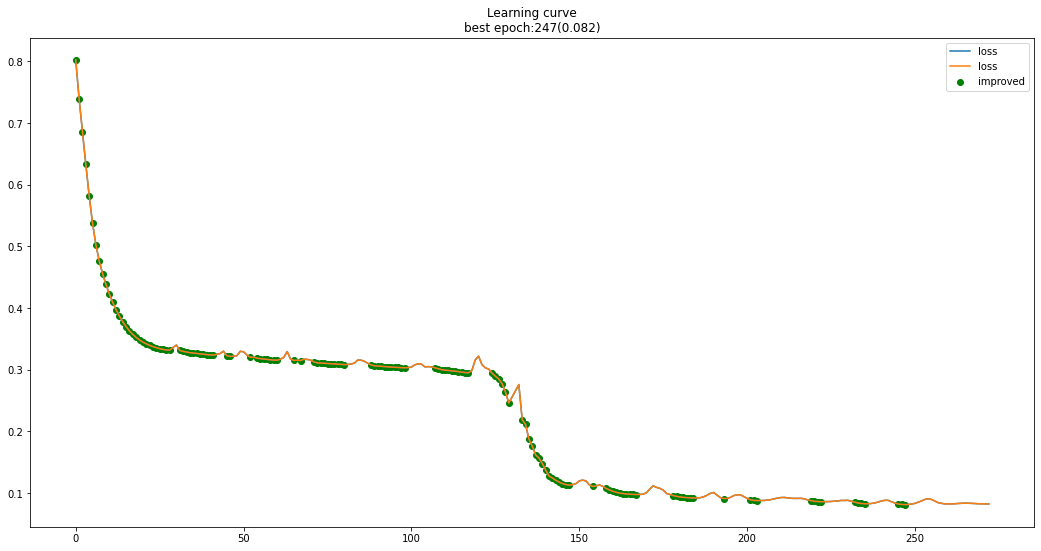

In [135]:
plot_learning_curve(history, 'loss')

### 12 MultiHead Attention - BiLSTM Model

### 12.1 MultiHead Attention - BiLSTM Architecture

In [136]:
def create_multihead_BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=input_dim, 
                                 return_sequences=True, 
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 )))
    model.add(MultiHeadAttention(head_num = x_train_sequence.shape[2]))
    model.add(Bidirectional(LSTM(input_dim, return_sequences=True, activation = 'tanh')))#,return_sequences=False))
    model.add(TimeDistributed(Dense(units=output_dim, activation = 'linear')))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)#, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    return model

model = create_multihead_BiLSTM()

### 12.2 MultiHead Attention - BiLSTM Model Training

In [137]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=16)
history = model.fit(x_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 12, 
                    validation_data = (x_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

..

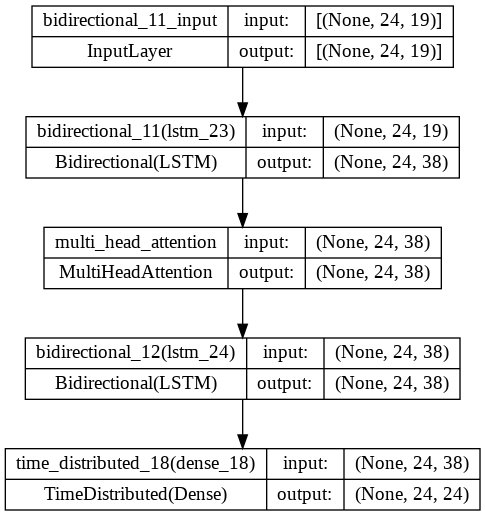

In [138]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 122


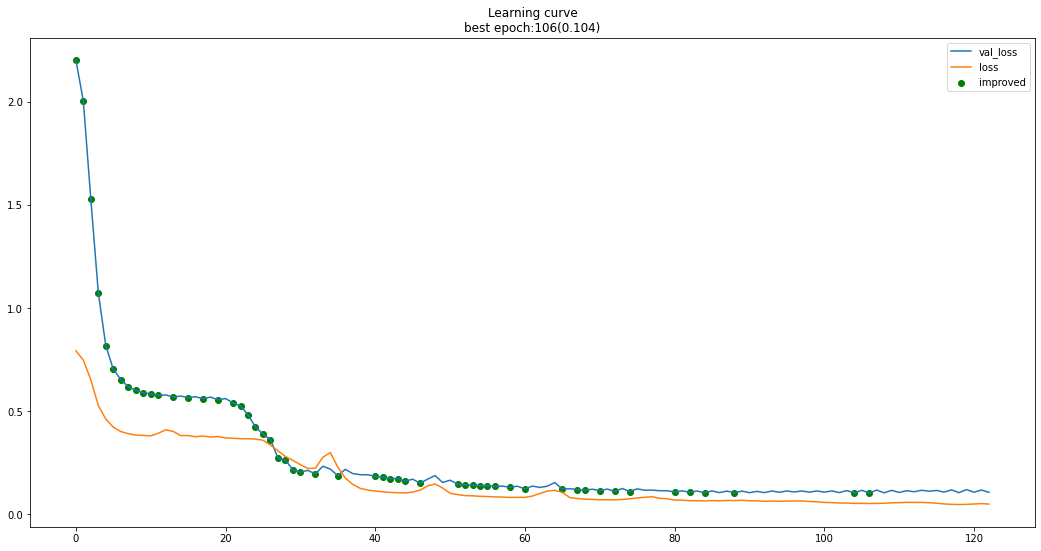

In [139]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

### 12.3 MultiHead Attention - BiLSTM Model Validation

In [140]:
pred_scaled = pd.DataFrame(np.mean(model.predict(x_test_sequence), axis = 0))
pred_all = pd.DataFrame(np.mean(pred_scaled, axis = 1))

pred_all.columns = ['Y_PRED']

1/1 [==============================] - 2s 2s/step


In [141]:
scorer_matt = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'MultiHeadAttention-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_matt.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
print(scorer_matt.score())
scorer_benchmark.add_rdr(scorer_matt)

2020-04-30 00:00:00 2022-03-31 00:00:00
0.5103819866720047


DTW          RMSE  RdR_SCORE                 MODEL_NAME
0  21910.770652   7112.950336   0.519818                     BiLSTM
1  59099.430044  12063.620641   0.000000                 RandomWalk
2  24605.420990   6402.221406   0.526478                    Seq2Seq
3  22482.519890   5171.134577   0.595463                 CNN-BiLSTM
4  23444.513717   6635.842410   0.526617                 TCN-BiLSTM
5  33656.092557   8326.851534   0.370136                 MDN-BiLSTM
6  24894.147765   6100.647626   0.536534           Attention-BiLSTM
7  18525.716709   5673.077172   0.608135    Seq2SeqAttention-BiLSTM
8  24806.072745   6749.613548   0.510382  MultiHeadAttention-BiLSTM

In [142]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)'

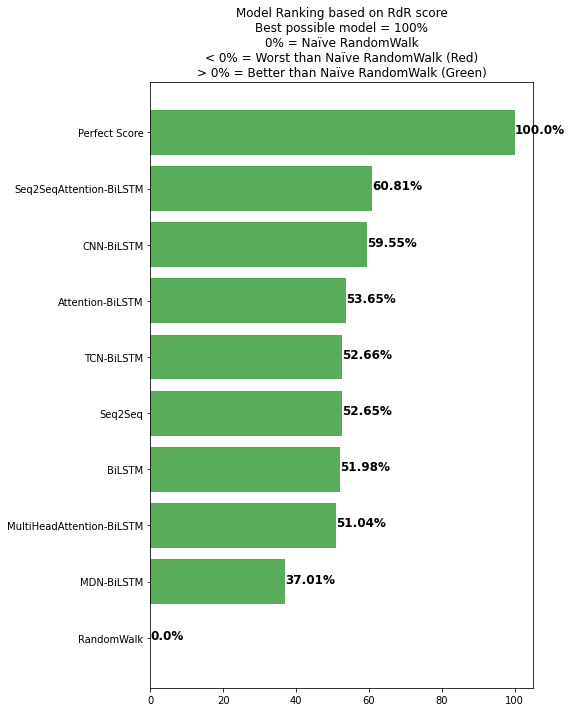

In [143]:
scorer_benchmark.plot_rdr_rank()

### 12.4 MultiHead Attention - BiLSTM Model Forecasting

In [144]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=20)

model = create_multihead_BiLSTM()

history = model.fit(x_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 12, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

pred_fscaled = pd.DataFrame(np.mean(model.predict(x_forecast), axis = 0))
pred_fscaled = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_fscaled.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

1/1 [==============================] - 2s 2s/step


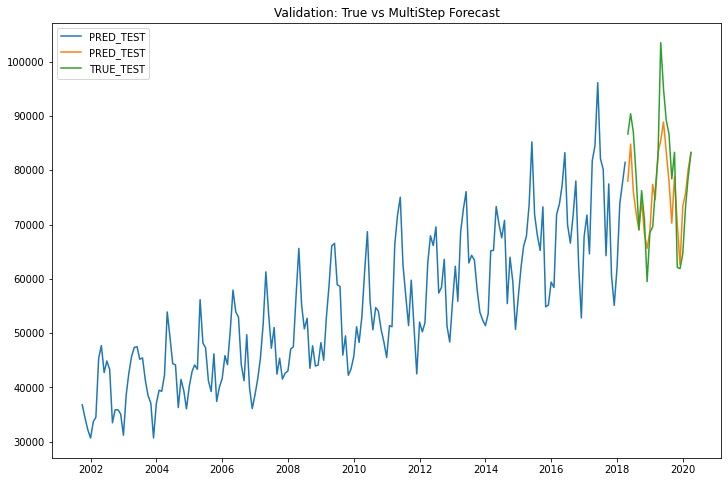

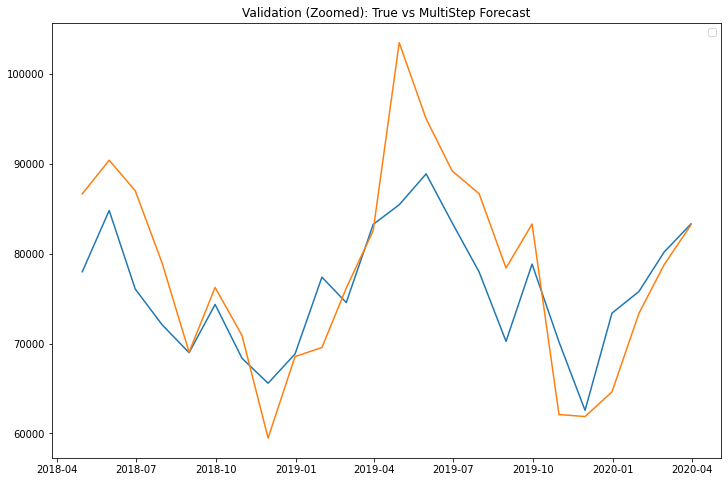

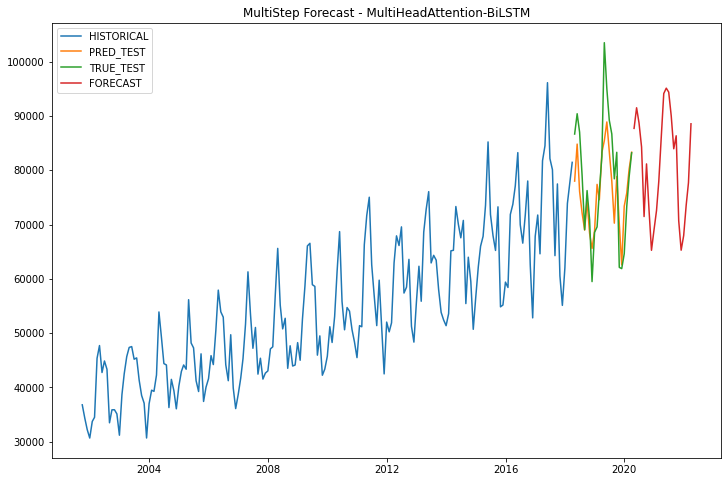

In [145]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

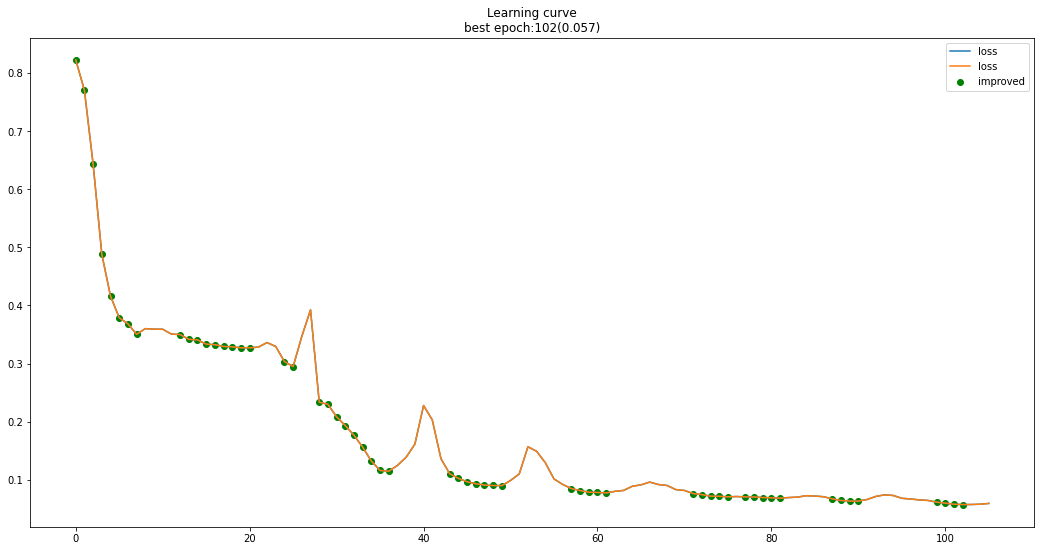

In [146]:
plot_learning_curve(history, 'loss')

## 13 Time2Vec - BiLSTM Model

### 13.1 Time2Vec - BiLSTM Architecture

In [149]:
class Time2Vec(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(Time2Vec, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [150]:
def create_t2v_bilstm():
    inp = Input(shape=(x_train_sequence.shape[1],
                   x_train_sequence.shape[2]))
    x = Time2Vec(120)(inp)
    x = Bidirectional(LSTM(48, activation='tanh', return_sequences = True))(x)
    x = Dense(y_train_sequence.shape[1])(x)

    model = Model(inp, x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    
    return model
    
model = create_t2v_bilstm()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 24, 19)]          0         
                                                                 
 time2_vec (Time2Vec)        (None, 24, 139)           5208      
                                                                 
 bidirectional_15 (Bidirecti  (None, 24, 96)           72192     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 24, 24)            2328      
                                                                 
Total params: 79,728
Trainable params: 79,728
Non-trainable params: 0
_________________________________________________________________


### 13.2 Time2Vec - BiLSTM Model Training

In [151]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)
history = model.fit(x_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 24, 
                    validation_data = (x_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

..

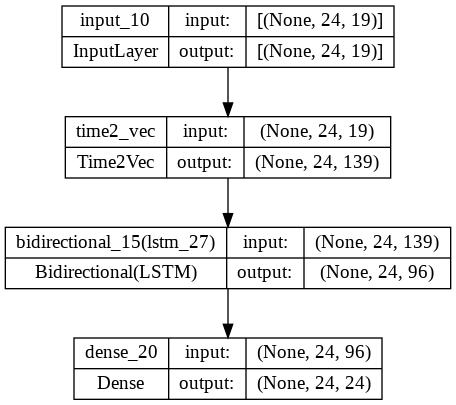

In [152]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 103


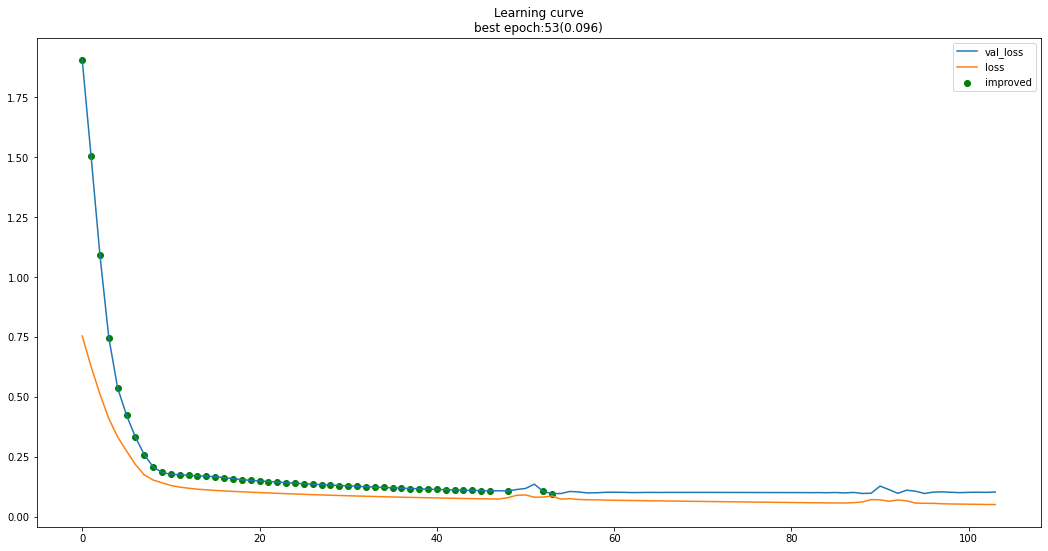

In [153]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

### 13.3 Time2Vec - BiLSTM Model Validation

In [154]:
pred_all = pd.DataFrame(model.predict(x_forecast)[0,:].T)
pred_all = pd.DataFrame(np.mean(pred_all.T, axis = 1))
pred_all.columns = ['Y_PRED']

1/1 [==============================] - 1s 727ms/step


In [155]:
scorer_t2vbilstm = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'Time2Vec-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_t2vbilstm.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
print(scorer_t2vbilstm.score())
scorer_benchmark.add_rdr(scorer_t2vbilstm)

2020-04-30 00:00:00 2022-03-31 00:00:00
0.6389847501079295


DTW          RMSE  RdR_SCORE                 MODEL_NAME
0  21910.770652   7112.950336   0.519818                     BiLSTM
1  59099.430044  12063.620641   0.000000                 RandomWalk
2  24605.420990   6402.221406   0.526478                    Seq2Seq
3  22482.519890   5171.134577   0.595463                 CNN-BiLSTM
4  23444.513717   6635.842410   0.526617                 TCN-BiLSTM
5  33656.092557   8326.851534   0.370136                 MDN-BiLSTM
6  24894.147765   6100.647626   0.536534           Attention-BiLSTM
7  18525.716709   5673.077172   0.608135    Seq2SeqAttention-BiLSTM
8  24806.072745   6749.613548   0.510382  MultiHeadAttention-BiLSTM
9  20830.343569   4458.325965   0.638985            Time2Vec-BiLSTM

In [156]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)'

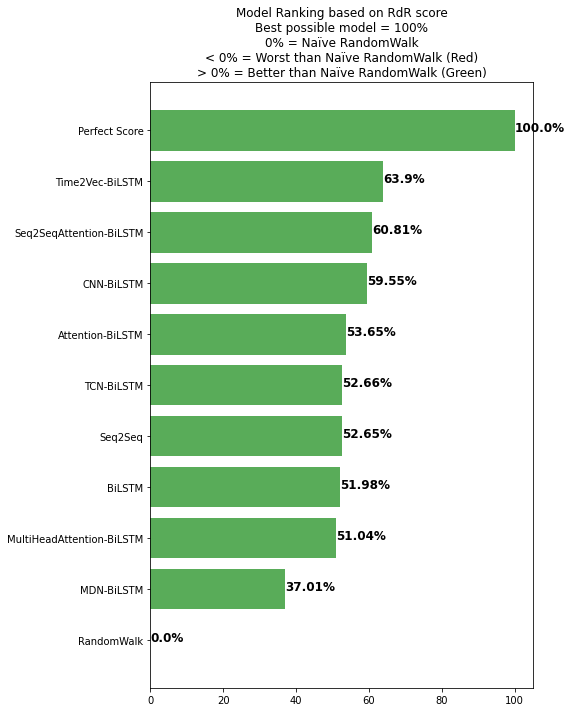

In [157]:
scorer_benchmark.plot_rdr_rank()

### 13.4 Time2Vec - BiLSTM Model Forecasting

In [158]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)

model = create_t2v_bilstm()

history = model.fit(x_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 24, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

pred_fscaled = pd.DataFrame(np.mean(model.predict(x_forecast), axis = 0))
pred_fscaled = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_fscaled.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast



X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 24, 19)]          0         
                                                                 
 time2_vec_1 (Time2Vec)      (None, 24, 139)           5208      
                                                                 
 bidirectional_16 (Bidirecti  (None, 24, 96)           72192     
 onal)                                                           
                                                                 
 dense_21 (Dense)            (None, 24, 24)            2328      
                                                                 
Total params: 79,728
Trainable params: 79,728
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 724ms/step


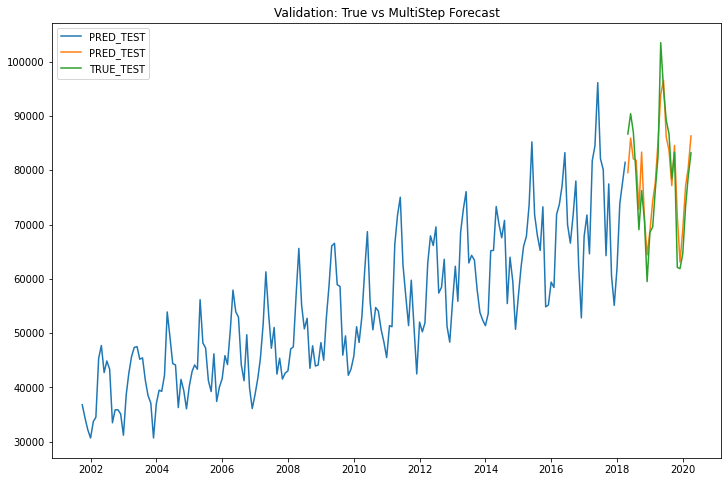

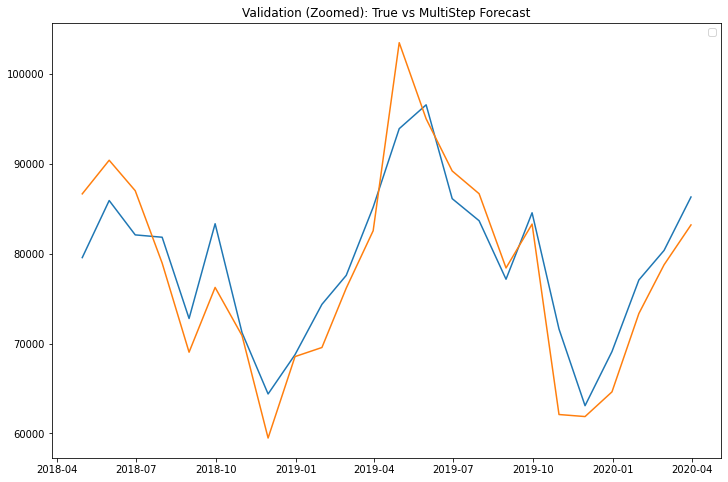

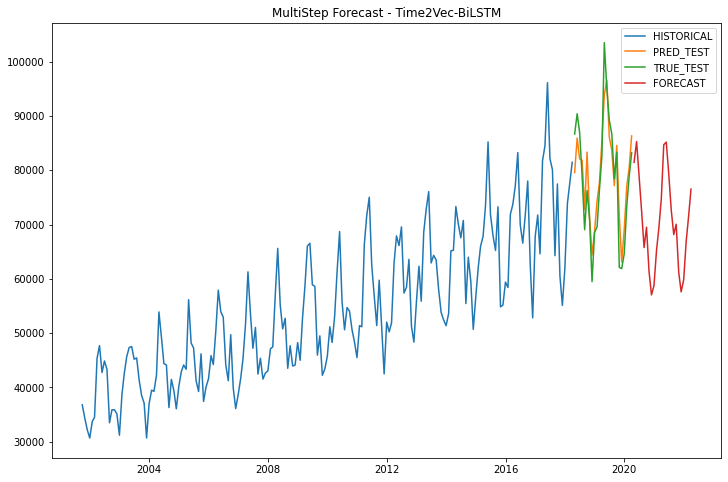

In [159]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

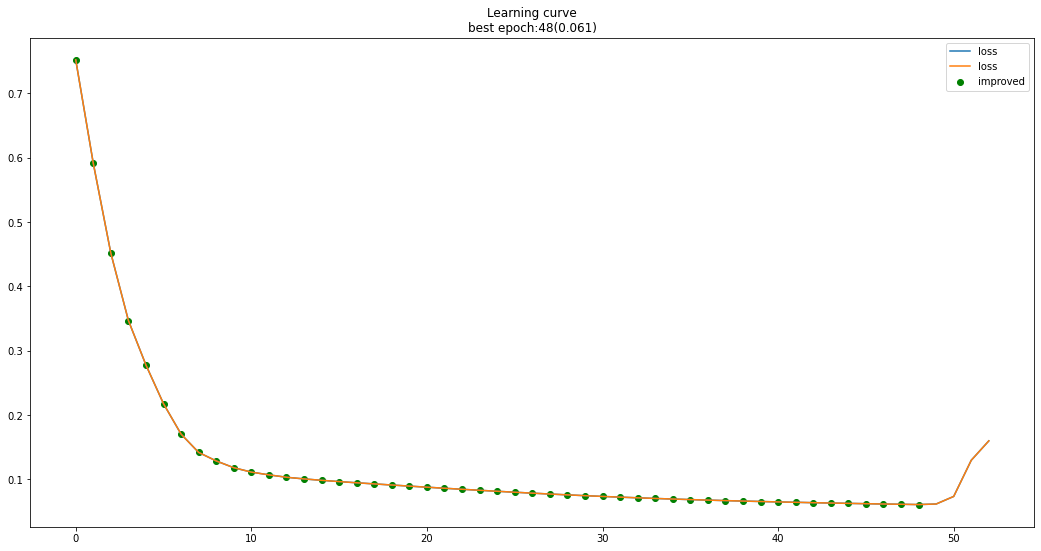

In [160]:
plot_learning_curve(history, 'loss')

## 14 Time2Vec - Transformer Model

### 14.1 Time2Vec - Transformer Architecture

In [161]:
class Time2Vec4TF(tf.keras.layers.Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vec4TF, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2

In [163]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class T2VTransformer(keras.Model):
    def __init__(
            self,
            num_hid=64, # embed_dim - num of features
            time_steps=7,
            num_head = 2,
            num_feed_forward=128, # pointwise dim
            num_layers_enc = 4,
            time_embedding = False,
    ):
        super().__init__()
        self.num_hid = num_hid
        if time_embedding:
            self.num_hid += 2
            self.tv = Time2Vec4TF(time_steps)
        else:
            self.tv = None
        self.numlayers_enc = num_layers_enc
        self.enc_input = layers.Input((time_steps, self.num_hid))
        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(self.num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )
        self.GlobalAveragePooling1D = layers.GlobalAveragePooling1D(data_format='channels_last')
        self.out = layers.Dense(units=time_steps, activation='linear')        
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        
    def call(self, inputs):
        if self.tv:
            x = self.tv(inputs)
            x = self.concat([inputs, x])
            x = self.encoder(x)
        else:
            x = self.encoder(inputs)
        x = self.GlobalAveragePooling1D(x)
        y = self.out(x)
        return y

In [164]:
def create_t2v_transformer():
    num_heads=2
    num_layers_enc=2
    num_feed_forward=64
    num_features = x_train_sequence.shape[2]
    time_steps = y_train_sequence.shape[1]
    epochs = 100
    batch_size = 128

    model = T2VTransformer(num_hid=num_features,
                           time_steps=time_steps,
                           time_embedding=True,
                           num_head=y_train_sequence.shape[1],
                           num_layers_enc=num_layers_enc,
                           num_feed_forward=num_feed_forward)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    
    return model
    
model = create_t2v_transformer()

### 14.2 Time2Vec - Transformer Model Training

In [165]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)
history = model.fit(x_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 24, 
                    validation_data = (x_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

...

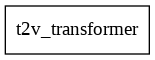

In [166]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 263


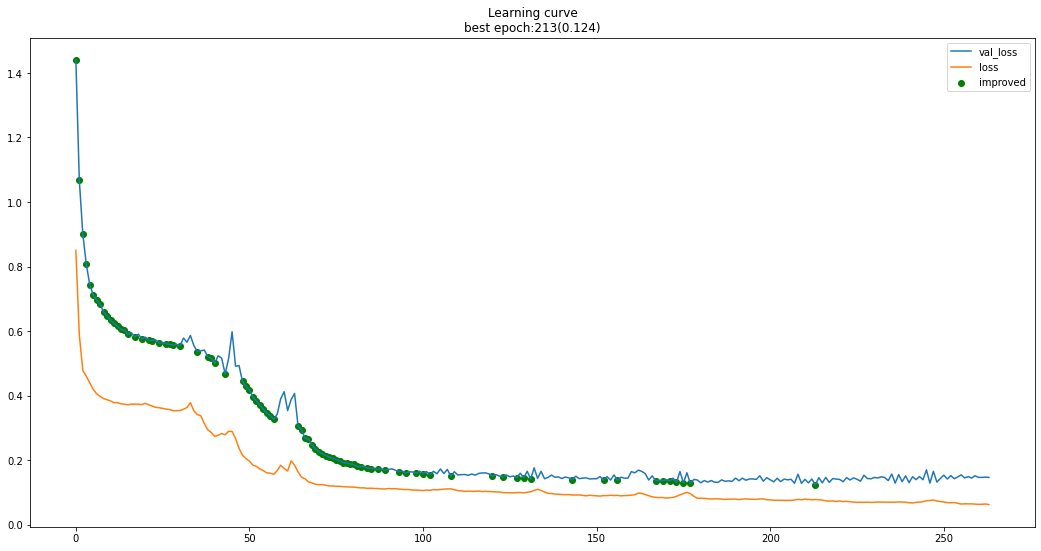

In [167]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

### 14.3 Time2Vec - Transformer Model Validation

In [168]:
pred_all = pd.DataFrame(model.predict(x_forecast)).T
pred_all.columns = ['Y_PRED']

1/1 [==============================] - 0s 313ms/step


In [169]:
scorer_t2vtf = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'Time2Vec-Transformer')

average_ensemble_model.append(y_pred)

scorer_t2vtf.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
print(scorer_t2vtf.score())
scorer_benchmark.add_rdr(scorer_t2vtf)

2020-04-30 00:00:00 2022-03-31 00:00:00
0.5656214961584076


DTW          RMSE  RdR_SCORE                 MODEL_NAME
0   21910.770652   7112.950336   0.519818                     BiLSTM
1   59099.430044  12063.620641   0.000000                 RandomWalk
2   24605.420990   6402.221406   0.526478                    Seq2Seq
3   22482.519890   5171.134577   0.595463                 CNN-BiLSTM
4   23444.513717   6635.842410   0.526617                 TCN-BiLSTM
5   33656.092557   8326.851534   0.370136                 MDN-BiLSTM
6   24894.147765   6100.647626   0.536534           Attention-BiLSTM
7   18525.716709   5673.077172   0.608135    Seq2SeqAttention-BiLSTM
8   24806.072745   6749.613548   0.510382  MultiHeadAttention-BiLSTM
9   20830.343569   4458.325965   0.638985            Time2Vec-BiLSTM
10  21409.021396   6110.256778   0.565621       Time2Vec-Transformer

In [170]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)'

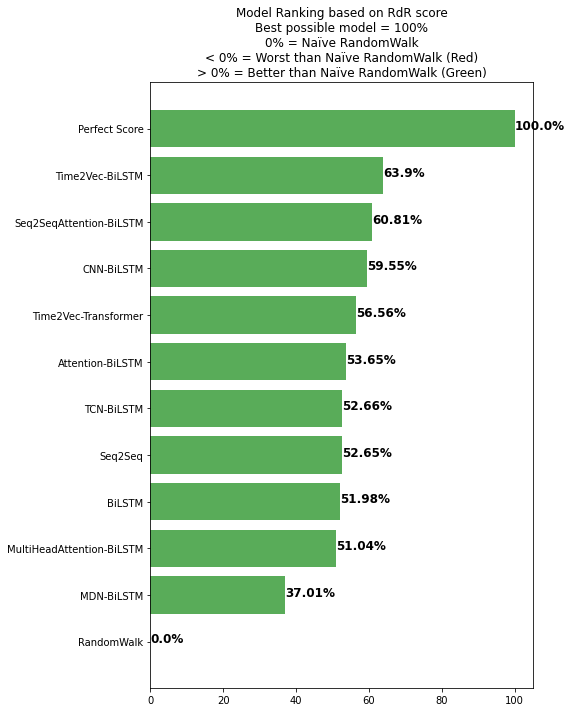

In [171]:
scorer_benchmark.plot_rdr_rank()

### 14.4 Time2Vec - Transdormer Model Forecasting

In [172]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)

model = create_t2v_transformer()

history = model.fit(x_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 24, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

pred_fscaled = pd.DataFrame(np.mean(model.predict(x_forecast), axis = 0))
pred_fscaled = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_fscaled.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

1/1 [==============================] - 1s 530ms/step


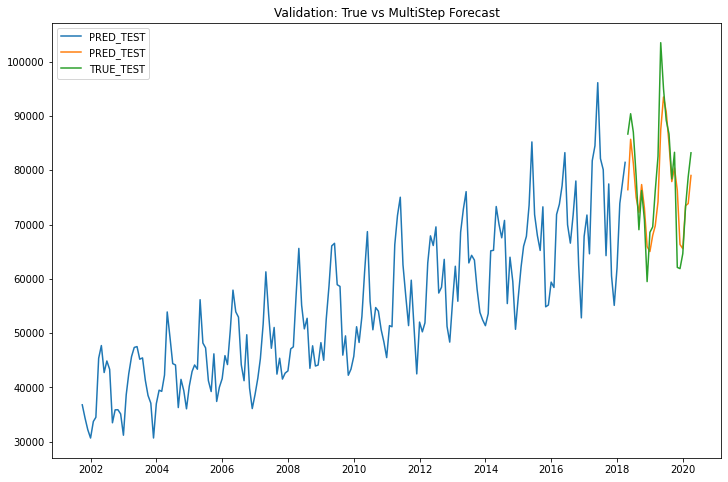

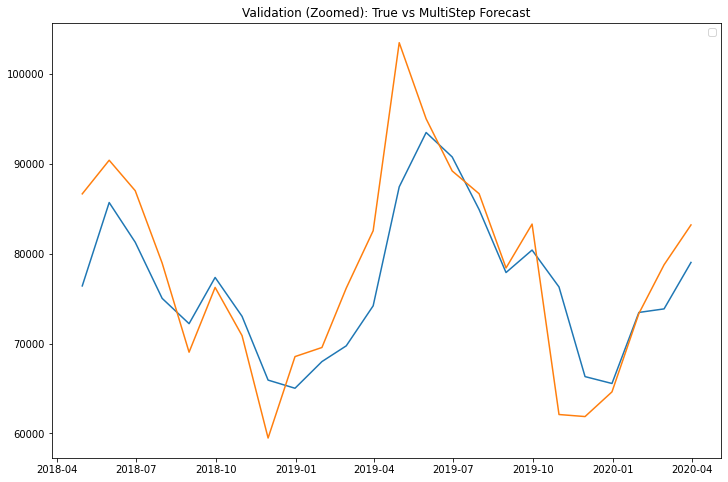

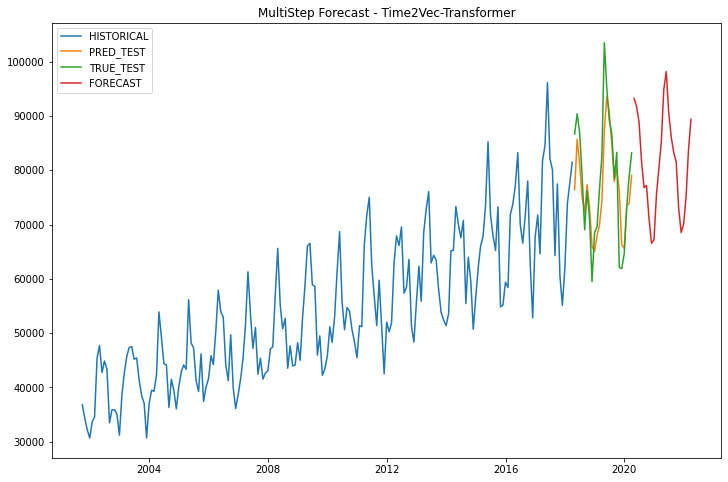

In [173]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

## 15 Average Ensemble Model

## 15.1 Average Ensemble Model Validation

In [174]:
average_ensemble_model_df = pd.DataFrame(np.mean(pd.concat(average_ensemble_model, axis = 1), axis = 1))
average_ensemble_model_df.columns = ['Y_PRED']
average_ensemble_model_df.index = y_pred.index

In [175]:
scorer_avg = RdR_scorer()

scorer_avg.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), average_ensemble_model_df.copy(), model_name = 'AverageEnsemble', freq = freq)
print(scorer_avg.score())
scorer_benchmark.add_rdr(scorer_avg)

2020-04-30 00:00:00 2022-03-31 00:00:00
0.6195316681365147


DTW          RMSE  RdR_SCORE                 MODEL_NAME
0   21910.770652   7112.950336   0.519818                     BiLSTM
1   59099.430044  12063.620641   0.000000                 RandomWalk
2   24605.420990   6402.221406   0.526478                    Seq2Seq
3   22482.519890   5171.134577   0.595463                 CNN-BiLSTM
4   23444.513717   6635.842410   0.526617                 TCN-BiLSTM
5   33656.092557   8326.851534   0.370136                 MDN-BiLSTM
6   24894.147765   6100.647626   0.536534           Attention-BiLSTM
7   18525.716709   5673.077172   0.608135    Seq2SeqAttention-BiLSTM
8   24806.072745   6749.613548   0.510382  MultiHeadAttention-BiLSTM
9   20830.343569   4458.325965   0.638985            Time2Vec-BiLSTM
10  21409.021396   6110.256778   0.565621       Time2Vec-Transformer
11  21085.564235   4875.578467   0.619532            AverageEnsemble

In [176]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 51.98% better than a naïve random decision. The mean forecast accuracy is 90.72% (around 88.04% and 93.13% of accuracy per forecasted datapoint)'

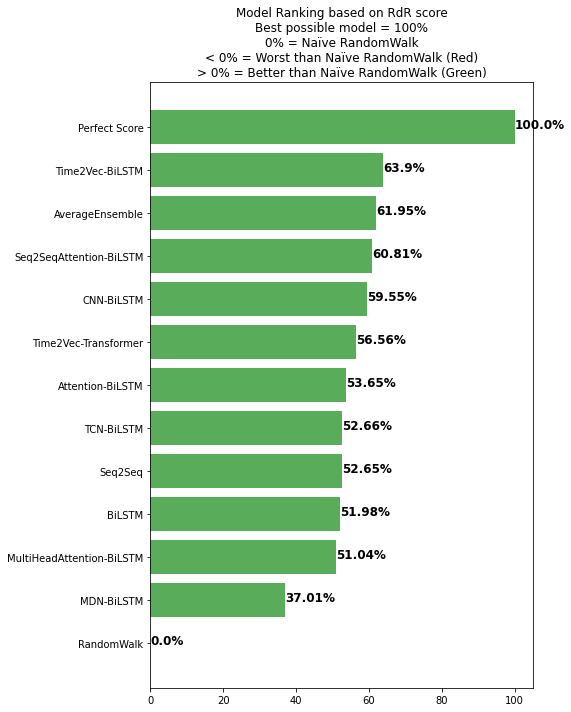

In [177]:
scorer_benchmark.plot_rdr_rank()

## 15.2 Average Ensemble Model Forecasting

In [178]:
average_ensemble_model_forecast_df = pd.DataFrame(np.mean(pd.concat(average_ensemble_model_forecast, axis = 1), axis = 1))
average_ensemble_model_forecast_df.columns = ['Y_PRED']
average_ensemble_model_forecast_df.index = pred_forecast.index

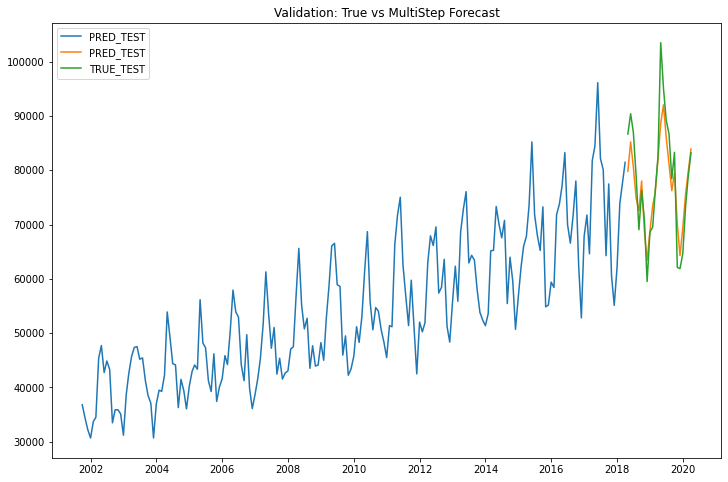

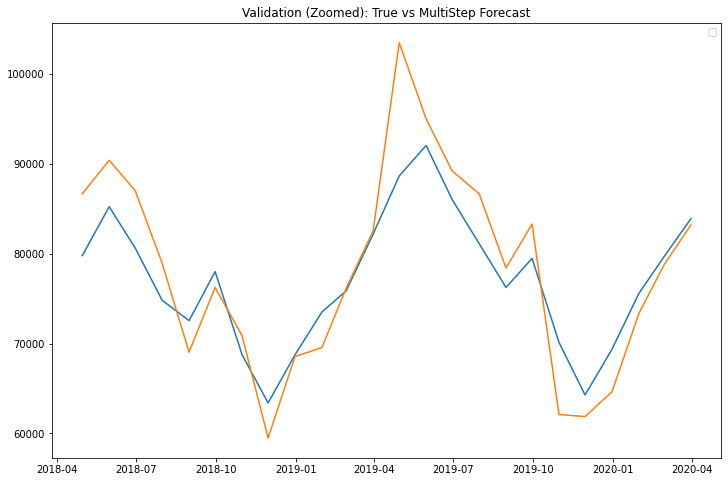

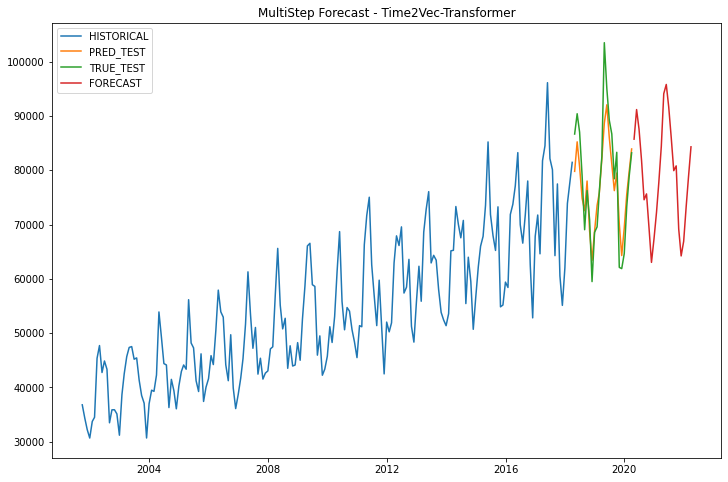

In [179]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             average_ensemble_model_df.copy(), 
             y_scaler_sequence, 
             average_ensemble_model_forecast_df.copy(), 
             y_scaler_forecast, 
             dict_ts_sequence)

### 16 Final Benchmarking

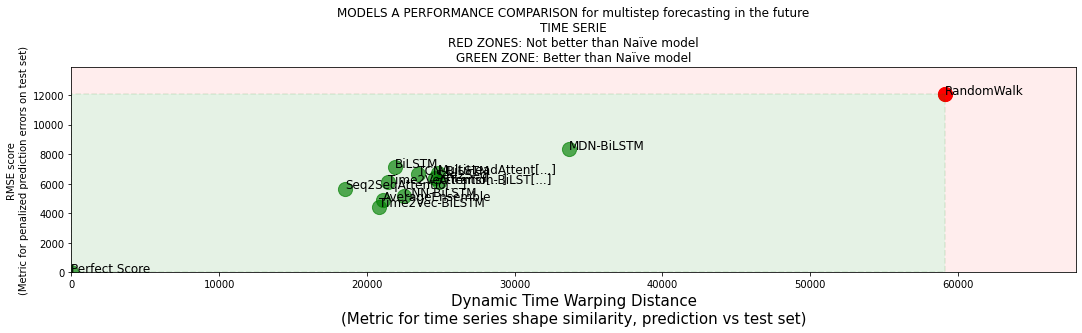

In [180]:
scorer_benchmark.plot_rdr(figsize=(18,8),
                          scatter_size = 200,
                         scatter_label_size = 12)

In [181]:
scores_df = scorer_benchmark.get_df_viz()

In [186]:
scores_df.sort_values('RdR_SCORE', ascending=False)

DTW          RMSE  RdR_SCORE                 MODEL_NAME
9   20830.343569   4458.325965   0.638985            Time2Vec-BiLSTM
11  21085.564235   4875.578467   0.619532            AverageEnsemble
7   18525.716709   5673.077172   0.608135    Seq2SeqAttention-BiLSTM
3   22482.519890   5171.134577   0.595463                 CNN-BiLSTM
10  21409.021396   6110.256778   0.565621       Time2Vec-Transformer
6   24894.147765   6100.647626   0.536534           Attention-BiLSTM
4   23444.513717   6635.842410   0.526617                 TCN-BiLSTM
2   24605.420990   6402.221406   0.526478                    Seq2Seq
0   21910.770652   7112.950336   0.519818                     BiLSTM
8   24806.072745   6749.613548   0.510382  MultiHeadAttention-BiLSTM
5   33656.092557   8326.851534   0.370136                 MDN-BiLSTM
1   59099.430044  12063.620641   0.000000                 RandomWalk